# Rice disease v.0.2

Huge Kaggle 12G dataset, 4 classes (3 disease + 1 healthy), Naive Approach

https://www.kaggle.com/ellyanalinden/googlenet

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets,transforms, models
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings('ignore')

## Params

In [2]:
RANDOM_SEED = 9
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

TRAIN_SIZE = 0.9

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

avail = torch.cuda.is_available()
print(f'CUDA available: {avail}')
    
if avail:
    print(f'Device: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    print(f'Memory allocated: {torch.cuda.memory_allocated()}')
    print(f'Memory cached:    {torch.cuda.memory_cached()}')

CUDA available: True
Device: GeForce GTX 960
Memory allocated: 0
Memory cached:    0


## Utils

In [4]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [5]:
def show_images(loader, class_names, nrow=5, n_batches=1, figsize=(12,4)):
    # Grab the first batch of 10 images
    images = None
    labels = []
    
    for b, (img, lbl) in enumerate(loader): 
        if n_batches is not None and b >= n_batches:
            break
        
        images = img if images is None else torch.cat((images, img), dim=0)
        labels.extend(lbl.numpy())
        
    labels = np.array(labels).reshape(-1, nrow)
    
    # Print the labels
    print('Labels:\n', labels)
    print('\nClasses:', ' | '.join(np.array([class_names[i] for i in labels[0, :5]])), '...')

    im = make_grid(images, nrow=nrow)  # the default nrow is 8

    # Inverse normalize the images
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    im_inv = inv_normalize(im)

    # Print the images
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

In [6]:
def plot_train_results(train_losses, valid_losses, train_corrects, valid_corrects, train_len, valid_len):
    plt.figure(figsize=(14,5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='training loss')
    plt.plot(valid_losses, label='validation loss')
    plt.title('Loss at the end of each epoch')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot([100*t/train_len for t in train_corrects], label='training accuracy')
    plt.plot([100*t/valid_len for t in valid_corrects], label='validation accuracy')
    plt.title('Accuracy at the end of each epoch')
    plt.ylim((0, 100))
    plt.grid(True)
    plt.legend()

In [7]:
def plot_confusion_matrix(y_true, y_pred, class_names, figsize = (4,3)):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, class_names, class_names)
    plt.figure(figsize=figsize)
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")
    plt.show()

In [8]:
def evaluate_model(model, data_loader, device, mark):
    model.eval()
    with torch.no_grad():
        y_evals = []
        y_valids = []

        for X_valid, y_valid in data_loader:
            y_eval = model(X_valid.to(device)).cpu()
            y_evals += list(torch.argmax(y_eval, axis=1).numpy())
            y_valids += list(y_valid.numpy())

    plot_confusion_matrix(y_valids, y_evals, data_loader.dataset.classes)

    print(f'{mark} accuracy:', round((np.array(y_valids) == np.array(y_evals)).sum()*100/len(y_evals), 2) , '%')

In [9]:
def save_progress(model, optimizer, train_losses, valid_losses, train_corrects, valid_corrects, prefix, folder):
    torch.save(model.state_dict(), f'{folder}/model_{prefix}.pt')
    torch.save(optimizer.state_dict(), f'{folder}/optimizer_{prefix}.pt')
    
    pickle.dump(train_losses, open(f'{folder}/train_losses_{prefix}.pkl', 'wb'))
    pickle.dump(valid_losses, open(f'{folder}/valid_losses_{prefix}.pkl', 'wb'))
    pickle.dump(train_corrects, open(f'{folder}/train_corrects_{prefix}.pkl', 'wb'))
    pickle.dump(valid_corrects, open(f'{folder}/valid_corrects_{prefix}.pkl', 'wb'))

In [10]:
def restore_progress(model, optimizer, prefix, folder):
    model.load_state_dict(torch.load(f'{folder}/model_{prefix}.pt'))
    optimizer.load_state_dict(torch.load(f'{folder}/optimizer_{prefix}.pt'))
    
    train_losses = pickle.load(open(f'{folder}/train_losses_{prefix}.pkl', 'rb'))
    valid_losses = pickle.load(open(f'{folder}/valid_losses_{prefix}.pkl', 'rb'))
    train_corrects = pickle.load(open(f'{folder}/train_corrects_{prefix}.pkl', 'rb'))
    valid_corrects = pickle.load(open(f'{folder}/valid_corrects_{prefix}.pkl', 'rb'))
    
    return train_losses, valid_losses, train_corrects, valid_corrects

## Data

In [11]:
img_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(30),
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([transforms.Resize(224),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])])
}

In [12]:
data_folder = 'data/kaggle12Gb/LabelledRice/Labelled'

In [13]:
all_data = datasets.ImageFolder(data_folder)
img_counts = Counter([img[1] for img in all_data.imgs])
cls_counts = {k:img_counts[i] for k,i in all_data.class_to_idx.items()}

In [14]:
print(all_data.class_to_idx)
print(cls_counts)
print('Total: ', len(all_data))

print('\nInitial stratification:')
print({cls : f'{round(100*cnt/len(all_data), 2)}%' for cls,cnt in cls_counts.items()})

{'BrownSpot': 0, 'Healthy': 1, 'Hispa': 2, 'LeafBlast': 3}
{'BrownSpot': 523, 'Healthy': 1488, 'Hispa': 565, 'LeafBlast': 779}
Total:  3355

Initial stratification:
{'BrownSpot': '15.59%', 'Healthy': '44.35%', 'Hispa': '16.84%', 'LeafBlast': '23.22%'}


In [15]:
all_cls = np.array([img[1] for img in all_data.imgs])
idx_to_class = np.array([[i, img] for i, img in enumerate(all_cls)])
np.random.shuffle(idx_to_class)

In [16]:
train_idx = []
valid_idx = []

class_idx = list(all_data.class_to_idx.values())
for i in class_idx:
    class_items = idx_to_class[idx_to_class[:, 1] == i][:, 0]
    train_len = int(len(class_items)*TRAIN_SIZE)
    
    train_idx += list(class_items[:train_len])
    valid_idx += list(class_items[train_len:])

assert set(train_idx) | set(valid_idx) == set(range(len(all_data)))

In [17]:
# ensure stratification
print('Initial stratification:')
print({cls : f'{round(100*cnt/len(all_cls), 2)}%' for (cls, cnt) in Counter(all_cls).items()})

print('\nTrain stratification:')
train_cls = all_cls[train_idx]
print({cls : f'{round(100*cnt/len(train_cls), 2)}%' for (cls, cnt) in Counter(train_cls).items()})

print('\nValidation stratification:')
valid_cls = all_cls[valid_idx]
print({cls : f'{round(100*cnt/len(valid_cls), 2)}%' for (cls, cnt) in Counter(valid_cls).items()})

Initial stratification:
{0: '15.59%', 1: '44.35%', 2: '16.84%', 3: '23.22%'}

Train stratification:
{0: '15.57%', 1: '44.37%', 2: '16.83%', 3: '23.23%'}

Validation stratification:
{0: '15.73%', 1: '44.21%', 2: '16.91%', 3: '23.15%'}


In [18]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [19]:
train_loader = DataLoader(datasets.ImageFolder(data_folder, transform=img_transforms['train']), 
                          batch_size=10, 
                          sampler=train_sampler,
                          pin_memory=False,
                          num_workers=4)
valid_loader = DataLoader(datasets.ImageFolder(data_folder, transform=img_transforms['valid']), 
                          batch_size=100, 
                          sampler=valid_sampler,
                          pin_memory=False,
                          num_workers=4)

In [20]:
# show_images(train_loader, all_data.classes, nrow=8, n_batches=1, figsize=(28, 7))

## Model

In [21]:
def train(model, criterion, optimizer, 
          train_loader, valid_loader, 
          n_epoch, device=DEVICE):
    start_time = time.time()

    train_losses = []
    valid_losses = []
    train_corrects = []
    valid_corrects = []
    
    train_len = len(train_loader.sampler.indices)
    valid_len = len(valid_loader.sampler.indices)
    n_train_batches = int(train_len/train_loader.batch_size)
    n_valid_batches = int(valid_len/valid_loader.batch_size)
    
    print('Begin...')
    
    for i in range(n_epoch):
        
        # train
        
        train_correct = 0
        
        for b, (X_train, y_train) in enumerate(train_loader):
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            optimizer.zero_grad()
            
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            
            y_pred = torch.max(y_pred, dim=1)[1]
            train_correct += (y_pred == y_train).sum()
            
            if b%100 == 0:
                print(f'---- batch: {b}({n_train_batches})')
            
        loss_val = round(float(loss), 2)
        correct_pct = round(train_correct.item()*100/train_len, 2)
        print(f'Epoch: {i+1}\tTRAIN\tLoss: {loss_val}\tCorrect: {train_correct}/{train_len}({correct_pct}%)')
    
        train_losses.append(loss_val)
        train_corrects.append(train_correct)
        
        # validation
        
        valid_correct = 0
        y_evals = []
        y_valids = []
        
        with torch.no_grad():
            for b, (X_valid, y_valid) in enumerate(valid_loader):
                X_valid = X_valid.to(device)
                y_valid = y_valid.to(device)
                y_eval = model(X_valid)
                loss = criterion(y_eval, y_valid)
                
                y_eval = torch.max(y_eval, dim=1)[1]
                valid_correct += (y_eval == y_valid).sum()
                y_evals += list(y_eval.cpu().view(-1))
                y_valids += list(y_valid.cpu().view(-1))
            
        loss_val = round(float(loss), 2)
        correct_pct = round(valid_correct.item()*100/valid_len, 2)
        print(f'\t\tVALID.:\tLoss: {loss_val}\tCorrect: {valid_correct}/{valid_len}({correct_pct}%)')
        print('----------------------------------------')
    
        valid_losses.append(loss_val)
        valid_corrects.append(valid_correct)
        
        # plot results
        plot_confusion_matrix(y_valids, y_evals, train_loader.dataset.classes)
        
        # save results
        if (i+1)%50==0:
            save_progress(model, optimizer, train_losses, valid_losses, train_corrects, valid_corrects, f'12_24_120_84_e{i+1}', 'progress')

    end_time = time.time()
    print(f'End.\nDuration: {time.time() - start_time:.0f} seconds')
    
    return train_losses, valid_losses, train_corrects, valid_corrects

### Naive

In [22]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 12, 3, 1)
        self.conv2 = nn.Conv2d(12, 24, 3, 1)
        self.fc1 = nn.Linear(54*54*24, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 54*54*24)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)        

In [23]:
model = SimpleModel().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

count_parameters(model)
model

     324
      12
    2592
      24
 8398080
     120
   10080
      84
     336
       4
________
 8411656


SimpleModel(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=69984, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)

In [24]:
next(model.parameters()).is_cuda

True

In [25]:
# train_losses_prev, valid_losses_prev, train_corrects_prev, valid_corrects_prev = \
#     restore_progress(model, optimizer, f'12_24_120_84_e9', 'progress')

# model.train()

Begin...
---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 1	TRAIN	Loss: 0.99	Correct: 1451/3018(48.08%)
		VALID.:	Loss: 1.1	Correct: 180/337(53.41%)
----------------------------------------


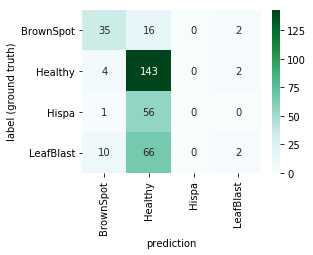

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 2	TRAIN	Loss: 1.2	Correct: 1534/3018(50.83%)
		VALID.:	Loss: 1.17	Correct: 179/337(53.12%)
----------------------------------------


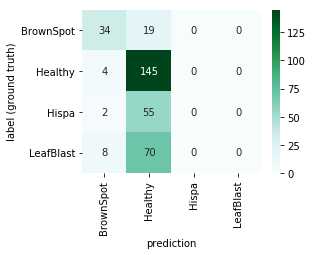

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 3	TRAIN	Loss: 0.82	Correct: 1540/3018(51.03%)
		VALID.:	Loss: 1.02	Correct: 182/337(54.01%)
----------------------------------------


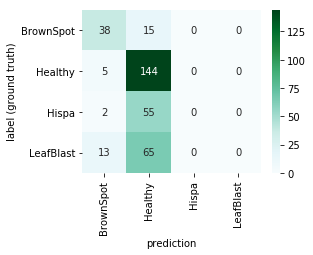

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 4	TRAIN	Loss: 1.19	Correct: 1553/3018(51.46%)
		VALID.:	Loss: 1.09	Correct: 176/337(52.23%)
----------------------------------------


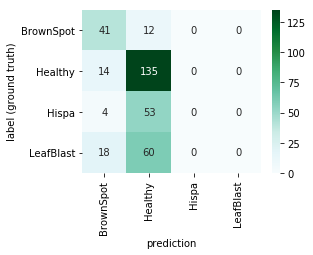

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 5	TRAIN	Loss: 0.98	Correct: 1563/3018(51.79%)
		VALID.:	Loss: 1.3	Correct: 176/337(52.23%)
----------------------------------------


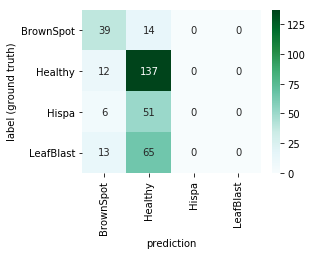

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 6	TRAIN	Loss: 1.16	Correct: 1545/3018(51.19%)
		VALID.:	Loss: 1.11	Correct: 177/337(52.52%)
----------------------------------------


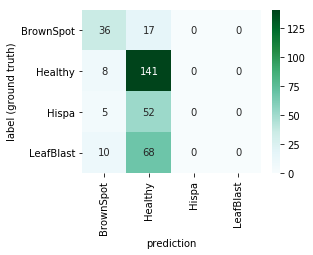

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 7	TRAIN	Loss: 0.75	Correct: 1586/3018(52.55%)
		VALID.:	Loss: 1.06	Correct: 179/337(53.12%)
----------------------------------------


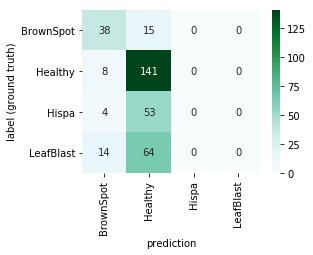

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 8	TRAIN	Loss: 1.53	Correct: 1567/3018(51.92%)
		VALID.:	Loss: 0.99	Correct: 169/337(50.15%)
----------------------------------------


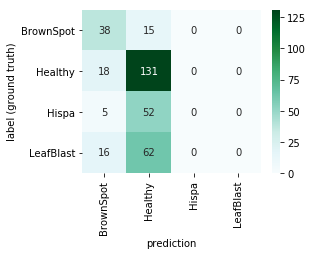

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 9	TRAIN	Loss: 1.27	Correct: 1560/3018(51.69%)
		VALID.:	Loss: 1.02	Correct: 180/337(53.41%)
----------------------------------------


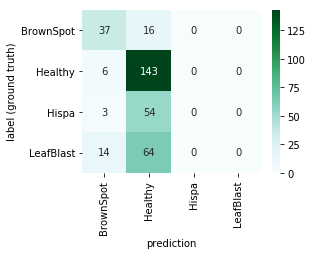

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 10	TRAIN	Loss: 0.83	Correct: 1578/3018(52.29%)
		VALID.:	Loss: 1.04	Correct: 174/337(51.63%)
----------------------------------------


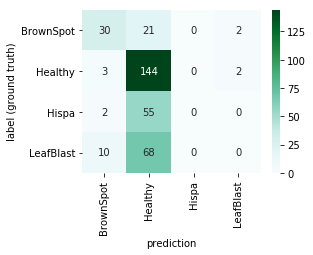

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 11	TRAIN	Loss: 0.73	Correct: 1580/3018(52.35%)
		VALID.:	Loss: 1.18	Correct: 178/337(52.82%)
----------------------------------------


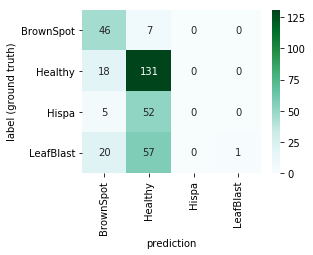

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 12	TRAIN	Loss: 1.26	Correct: 1571/3018(52.05%)
		VALID.:	Loss: 1.06	Correct: 171/337(50.74%)
----------------------------------------


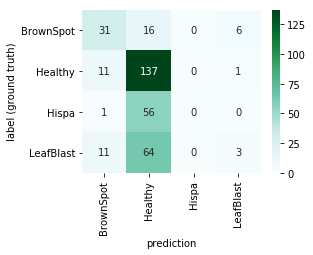

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 13	TRAIN	Loss: 1.39	Correct: 1593/3018(52.78%)
		VALID.:	Loss: 1.12	Correct: 182/337(54.01%)
----------------------------------------


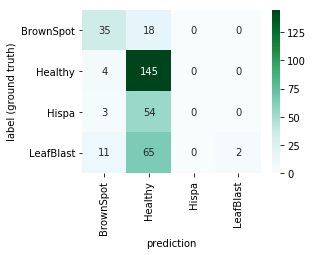

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 14	TRAIN	Loss: 0.93	Correct: 1567/3018(51.92%)
		VALID.:	Loss: 1.03	Correct: 182/337(54.01%)
----------------------------------------


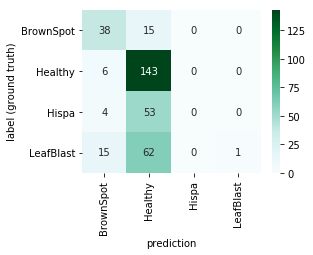

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 15	TRAIN	Loss: 0.88	Correct: 1604/3018(53.15%)
		VALID.:	Loss: 0.83	Correct: 182/337(54.01%)
----------------------------------------


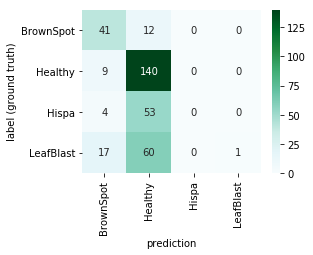

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 16	TRAIN	Loss: 0.98	Correct: 1636/3018(54.21%)
		VALID.:	Loss: 1.12	Correct: 182/337(54.01%)
----------------------------------------


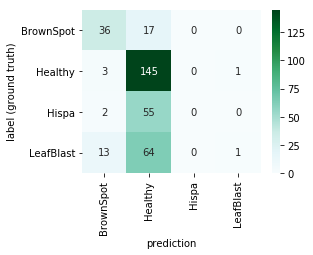

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 17	TRAIN	Loss: 1.31	Correct: 1584/3018(52.49%)
		VALID.:	Loss: 1.19	Correct: 182/337(54.01%)
----------------------------------------


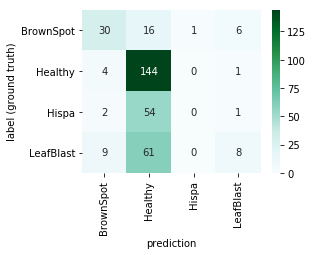

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 18	TRAIN	Loss: 1.23	Correct: 1603/3018(53.11%)
		VALID.:	Loss: 1.11	Correct: 188/337(55.79%)
----------------------------------------


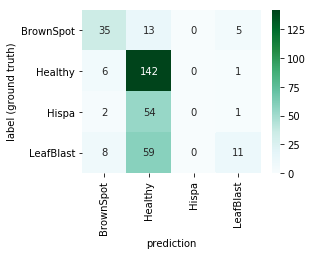

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 19	TRAIN	Loss: 1.15	Correct: 1590/3018(52.68%)
		VALID.:	Loss: 1.1	Correct: 195/337(57.86%)
----------------------------------------


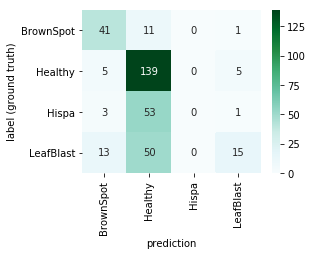

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 20	TRAIN	Loss: 1.01	Correct: 1579/3018(52.32%)
		VALID.:	Loss: 0.97	Correct: 182/337(54.01%)
----------------------------------------


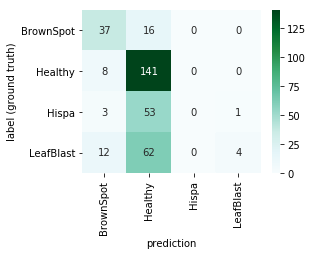

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 21	TRAIN	Loss: 1.01	Correct: 1618/3018(53.61%)
		VALID.:	Loss: 0.94	Correct: 180/337(53.41%)
----------------------------------------


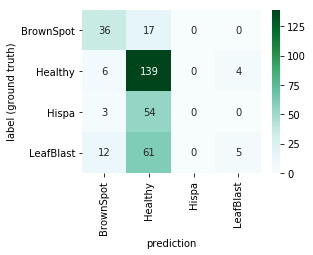

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 22	TRAIN	Loss: 0.75	Correct: 1603/3018(53.11%)
		VALID.:	Loss: 1.29	Correct: 178/337(52.82%)
----------------------------------------


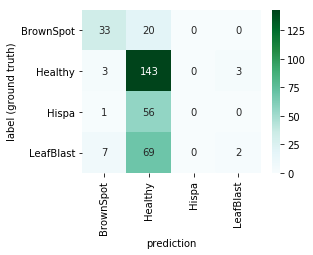

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 23	TRAIN	Loss: 0.83	Correct: 1629/3018(53.98%)
		VALID.:	Loss: 1.22	Correct: 188/337(55.79%)
----------------------------------------


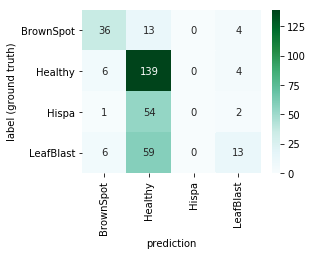

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 24	TRAIN	Loss: 1.42	Correct: 1638/3018(54.27%)
		VALID.:	Loss: 1.28	Correct: 187/337(55.49%)
----------------------------------------


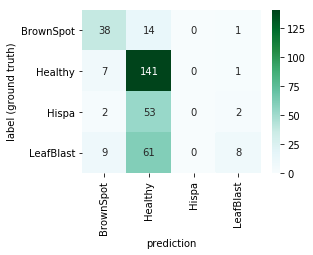

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 25	TRAIN	Loss: 0.77	Correct: 1619/3018(53.64%)
		VALID.:	Loss: 1.13	Correct: 187/337(55.49%)
----------------------------------------


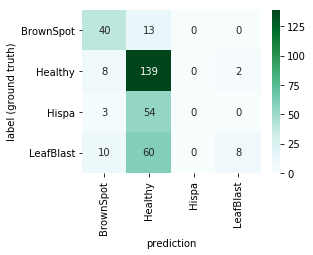

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 26	TRAIN	Loss: 1.31	Correct: 1645/3018(54.51%)
		VALID.:	Loss: 0.99	Correct: 183/337(54.3%)
----------------------------------------


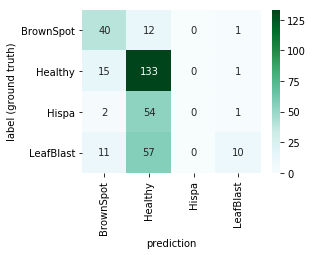

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 27	TRAIN	Loss: 1.21	Correct: 1649/3018(54.64%)
		VALID.:	Loss: 1.15	Correct: 176/337(52.23%)
----------------------------------------


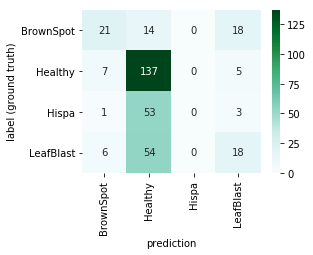

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 28	TRAIN	Loss: 0.97	Correct: 1642/3018(54.41%)
		VALID.:	Loss: 1.03	Correct: 189/337(56.08%)
----------------------------------------


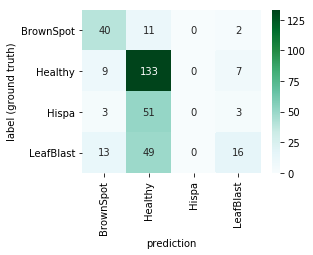

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 29	TRAIN	Loss: 1.1	Correct: 1594/3018(52.82%)
		VALID.:	Loss: 1.07	Correct: 185/337(54.9%)
----------------------------------------


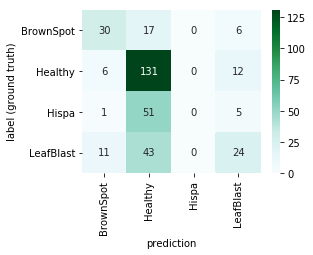

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 30	TRAIN	Loss: 1.69	Correct: 1648/3018(54.61%)
		VALID.:	Loss: 1.07	Correct: 192/337(56.97%)
----------------------------------------


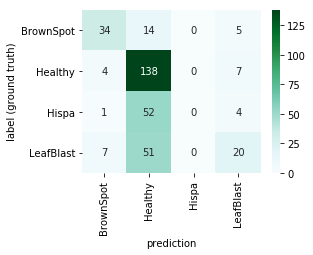

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 31	TRAIN	Loss: 1.65	Correct: 1673/3018(55.43%)
		VALID.:	Loss: 1.11	Correct: 180/337(53.41%)
----------------------------------------


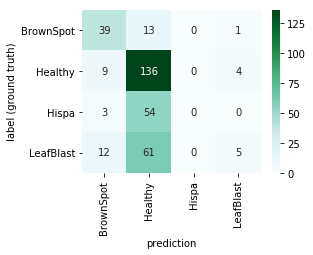

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 32	TRAIN	Loss: 0.79	Correct: 1681/3018(55.7%)
		VALID.:	Loss: 1.12	Correct: 190/337(56.38%)
----------------------------------------


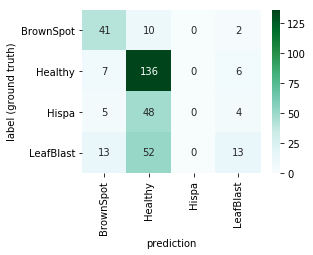

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 33	TRAIN	Loss: 0.57	Correct: 1662/3018(55.07%)
		VALID.:	Loss: 1.14	Correct: 192/337(56.97%)
----------------------------------------


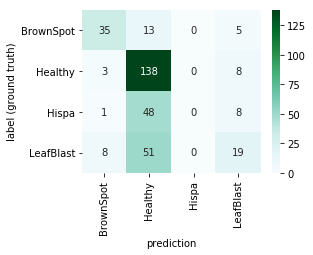

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 34	TRAIN	Loss: 1.17	Correct: 1713/3018(56.76%)
		VALID.:	Loss: 1.1	Correct: 189/337(56.08%)
----------------------------------------


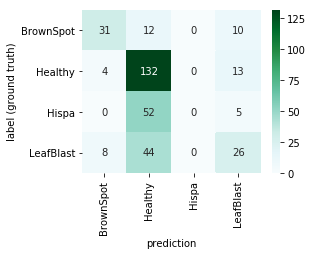

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 35	TRAIN	Loss: 1.42	Correct: 1693/3018(56.1%)
		VALID.:	Loss: 1.67	Correct: 187/337(55.49%)
----------------------------------------


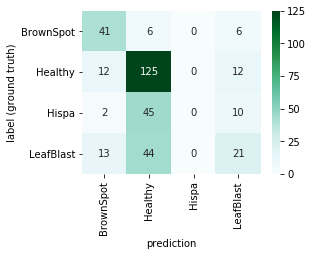

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 36	TRAIN	Loss: 1.54	Correct: 1676/3018(55.53%)
		VALID.:	Loss: 0.99	Correct: 192/337(56.97%)
----------------------------------------


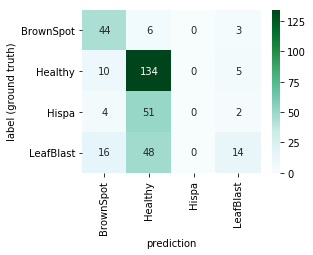

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 37	TRAIN	Loss: 0.83	Correct: 1713/3018(56.76%)
		VALID.:	Loss: 1.34	Correct: 194/337(57.57%)
----------------------------------------


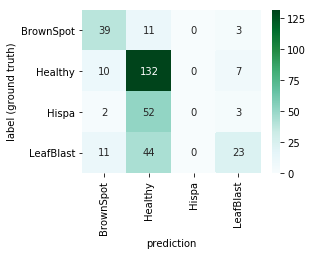

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 38	TRAIN	Loss: 0.62	Correct: 1712/3018(56.73%)
		VALID.:	Loss: 1.91	Correct: 198/337(58.75%)
----------------------------------------


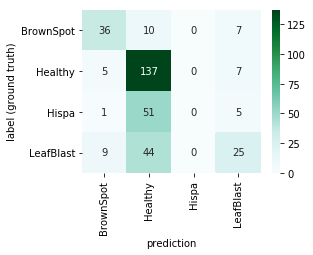

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 39	TRAIN	Loss: 1.07	Correct: 1732/3018(57.39%)
		VALID.:	Loss: 1.6	Correct: 192/337(56.97%)
----------------------------------------


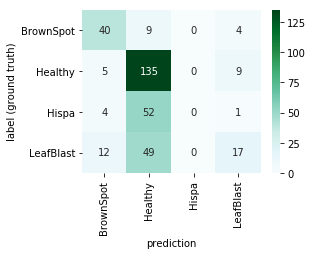

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 40	TRAIN	Loss: 0.6	Correct: 1756/3018(58.18%)
		VALID.:	Loss: 1.09	Correct: 191/337(56.68%)
----------------------------------------


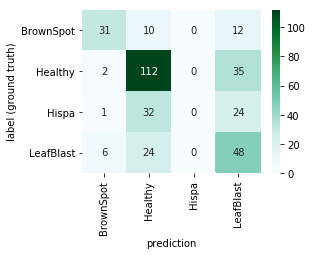

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 41	TRAIN	Loss: 0.98	Correct: 1715/3018(56.83%)
		VALID.:	Loss: 0.95	Correct: 192/337(56.97%)
----------------------------------------


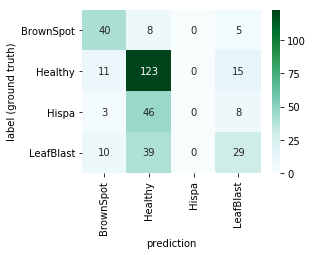

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 42	TRAIN	Loss: 1.4	Correct: 1658/3018(54.94%)
		VALID.:	Loss: 0.9	Correct: 196/337(58.16%)
----------------------------------------


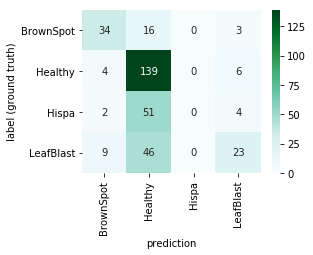

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 43	TRAIN	Loss: 0.83	Correct: 1745/3018(57.82%)
		VALID.:	Loss: 0.9	Correct: 193/337(57.27%)
----------------------------------------


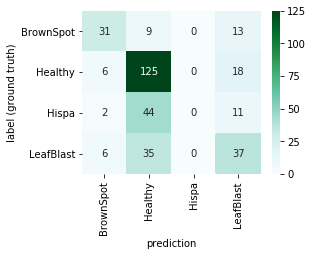

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 44	TRAIN	Loss: 1.13	Correct: 1760/3018(58.32%)
		VALID.:	Loss: 1.43	Correct: 195/337(57.86%)
----------------------------------------


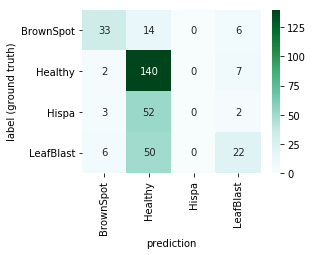

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 45	TRAIN	Loss: 0.87	Correct: 1759/3018(58.28%)
		VALID.:	Loss: 1.04	Correct: 198/337(58.75%)
----------------------------------------


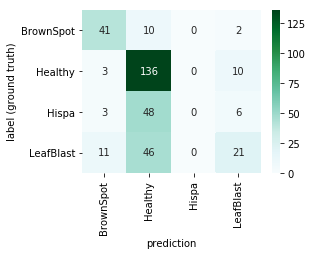

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 46	TRAIN	Loss: 1.14	Correct: 1774/3018(58.78%)
		VALID.:	Loss: 1.07	Correct: 204/337(60.53%)
----------------------------------------


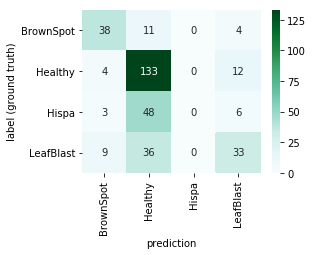

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 47	TRAIN	Loss: 0.63	Correct: 1759/3018(58.28%)
		VALID.:	Loss: 1.15	Correct: 197/337(58.46%)
----------------------------------------


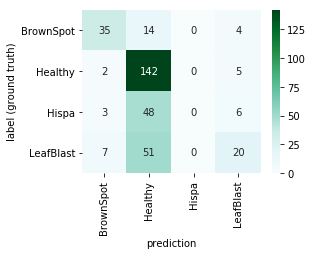

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 48	TRAIN	Loss: 1.03	Correct: 1790/3018(59.31%)
		VALID.:	Loss: 1.22	Correct: 201/337(59.64%)
----------------------------------------


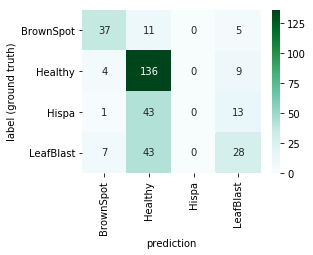

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 49	TRAIN	Loss: 0.74	Correct: 1765/3018(58.48%)
		VALID.:	Loss: 1.14	Correct: 199/337(59.05%)
----------------------------------------


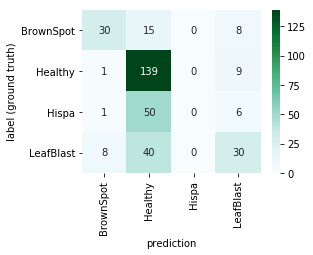

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 50	TRAIN	Loss: 1.14	Correct: 1809/3018(59.94%)
		VALID.:	Loss: 1.22	Correct: 206/337(61.13%)
----------------------------------------


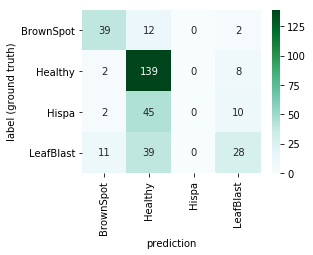

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 51	TRAIN	Loss: 1.03	Correct: 1782/3018(59.05%)
		VALID.:	Loss: 0.92	Correct: 201/337(59.64%)
----------------------------------------


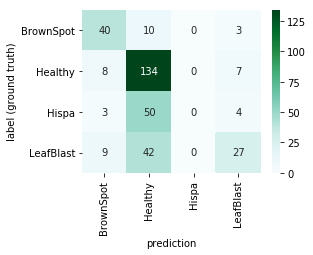

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 52	TRAIN	Loss: 1.14	Correct: 1818/3018(60.24%)
		VALID.:	Loss: 0.89	Correct: 212/337(62.91%)
----------------------------------------


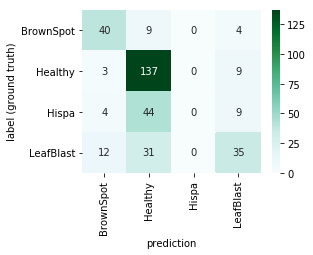

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 53	TRAIN	Loss: 0.97	Correct: 1816/3018(60.17%)
		VALID.:	Loss: 0.85	Correct: 206/337(61.13%)
----------------------------------------


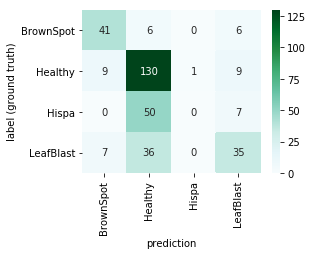

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 54	TRAIN	Loss: 0.83	Correct: 1794/3018(59.44%)
		VALID.:	Loss: 1.05	Correct: 203/337(60.24%)
----------------------------------------


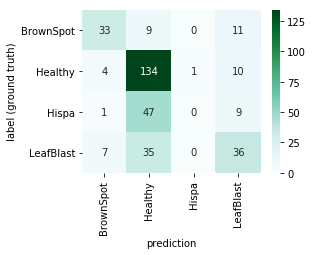

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 55	TRAIN	Loss: 0.77	Correct: 1800/3018(59.64%)
		VALID.:	Loss: 0.91	Correct: 205/337(60.83%)
----------------------------------------


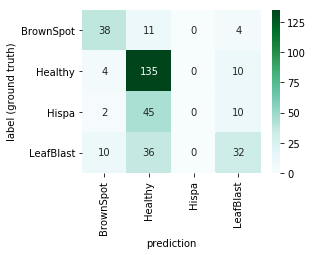

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 56	TRAIN	Loss: 0.96	Correct: 1838/3018(60.9%)
		VALID.:	Loss: 0.91	Correct: 209/337(62.02%)
----------------------------------------


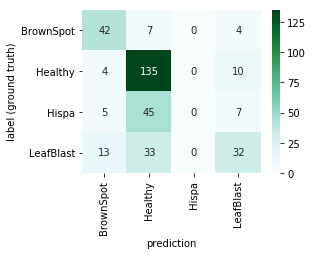

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 57	TRAIN	Loss: 0.86	Correct: 1837/3018(60.87%)
		VALID.:	Loss: 0.83	Correct: 199/337(59.05%)
----------------------------------------


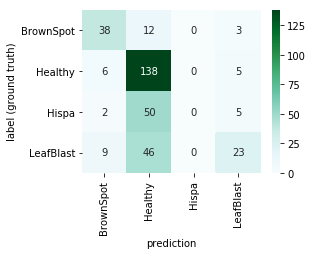

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 58	TRAIN	Loss: 1.16	Correct: 1852/3018(61.37%)
		VALID.:	Loss: 0.9	Correct: 202/337(59.94%)
----------------------------------------


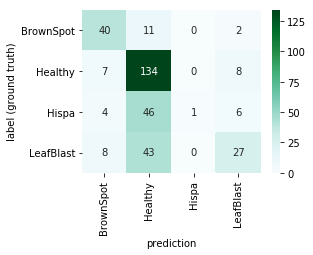

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 59	TRAIN	Loss: 1.28	Correct: 1834/3018(60.77%)
		VALID.:	Loss: 0.97	Correct: 212/337(62.91%)
----------------------------------------


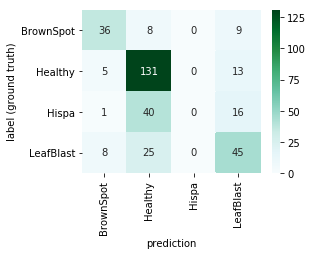

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 60	TRAIN	Loss: 0.79	Correct: 1843/3018(61.07%)
		VALID.:	Loss: 1.02	Correct: 204/337(60.53%)
----------------------------------------


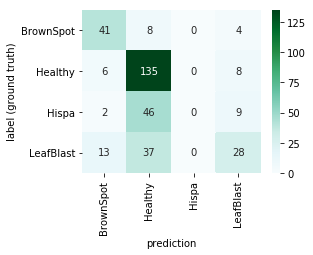

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 61	TRAIN	Loss: 1.06	Correct: 1822/3018(60.37%)
		VALID.:	Loss: 0.89	Correct: 213/337(63.2%)
----------------------------------------


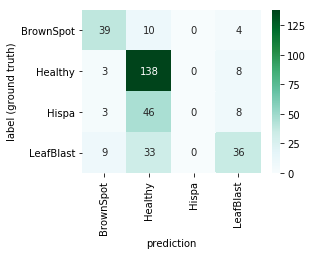

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 62	TRAIN	Loss: 1.24	Correct: 1833/3018(60.74%)
		VALID.:	Loss: 0.8	Correct: 201/337(59.64%)
----------------------------------------


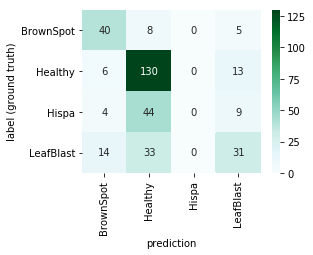

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 63	TRAIN	Loss: 0.86	Correct: 1823/3018(60.4%)
		VALID.:	Loss: 1.04	Correct: 203/337(60.24%)
----------------------------------------


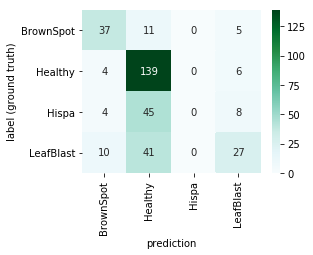

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 64	TRAIN	Loss: 1.5	Correct: 1860/3018(61.63%)
		VALID.:	Loss: 0.93	Correct: 208/337(61.72%)
----------------------------------------


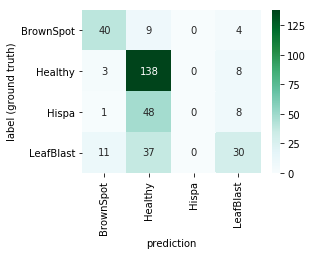

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 65	TRAIN	Loss: 0.56	Correct: 1858/3018(61.56%)
		VALID.:	Loss: 0.83	Correct: 209/337(62.02%)
----------------------------------------


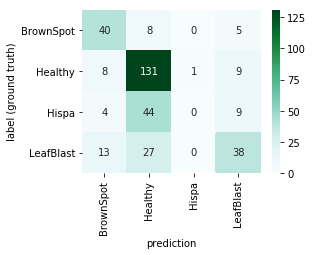

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 66	TRAIN	Loss: 0.55	Correct: 1868/3018(61.9%)
		VALID.:	Loss: 0.87	Correct: 211/337(62.61%)
----------------------------------------


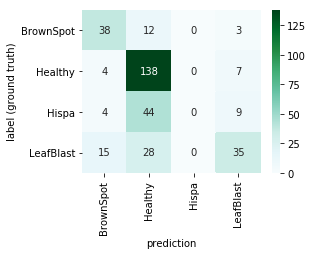

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 67	TRAIN	Loss: 0.57	Correct: 1851/3018(61.33%)
		VALID.:	Loss: 0.91	Correct: 209/337(62.02%)
----------------------------------------


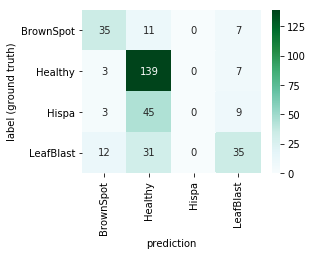

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 68	TRAIN	Loss: 1.05	Correct: 1831/3018(60.67%)
		VALID.:	Loss: 1.06	Correct: 205/337(60.83%)
----------------------------------------


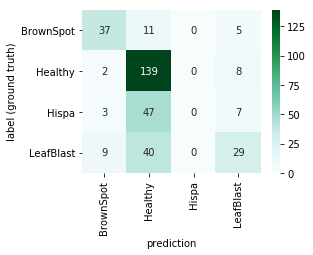

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 69	TRAIN	Loss: 1.41	Correct: 1858/3018(61.56%)
		VALID.:	Loss: 0.96	Correct: 211/337(62.61%)
----------------------------------------


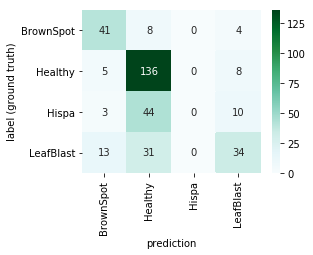

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 70	TRAIN	Loss: 0.94	Correct: 1860/3018(61.63%)
		VALID.:	Loss: 0.91	Correct: 211/337(62.61%)
----------------------------------------


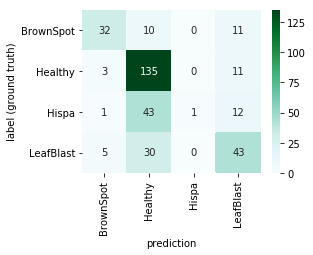

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 71	TRAIN	Loss: 1.07	Correct: 1875/3018(62.13%)
		VALID.:	Loss: 1.13	Correct: 220/337(65.28%)
----------------------------------------


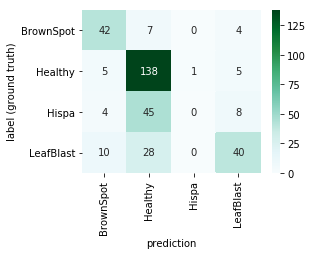

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 72	TRAIN	Loss: 0.87	Correct: 1858/3018(61.56%)
		VALID.:	Loss: 0.81	Correct: 219/337(64.99%)
----------------------------------------


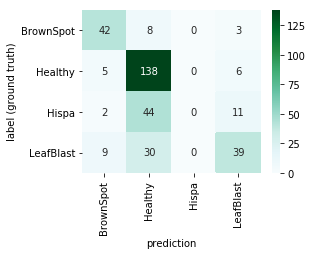

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 73	TRAIN	Loss: 0.61	Correct: 1899/3018(62.92%)
		VALID.:	Loss: 0.86	Correct: 220/337(65.28%)
----------------------------------------


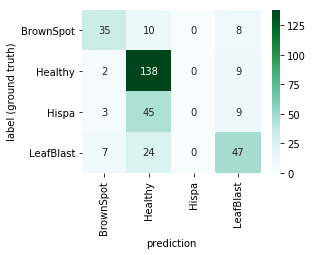

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 74	TRAIN	Loss: 1.58	Correct: 1856/3018(61.5%)
		VALID.:	Loss: 0.86	Correct: 213/337(63.2%)
----------------------------------------


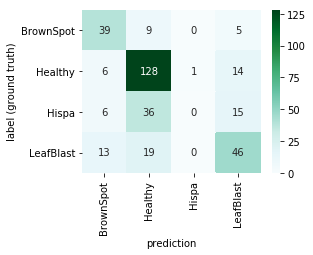

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 75	TRAIN	Loss: 1.55	Correct: 1841/3018(61.0%)
		VALID.:	Loss: 0.85	Correct: 223/337(66.17%)
----------------------------------------


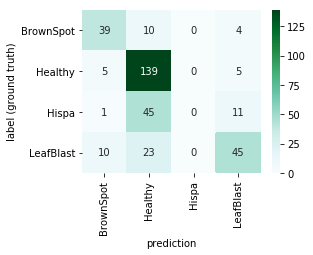

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 76	TRAIN	Loss: 1.06	Correct: 1856/3018(61.5%)
		VALID.:	Loss: 0.78	Correct: 212/337(62.91%)
----------------------------------------


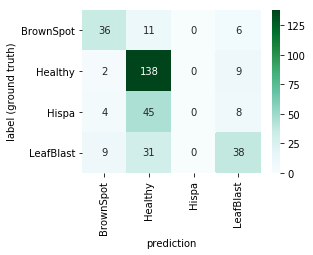

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 77	TRAIN	Loss: 1.03	Correct: 1878/3018(62.23%)
		VALID.:	Loss: 0.87	Correct: 216/337(64.09%)
----------------------------------------


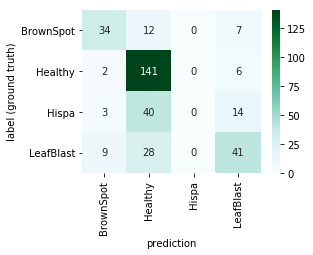

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 78	TRAIN	Loss: 0.77	Correct: 1905/3018(63.12%)
		VALID.:	Loss: 1.22	Correct: 203/337(60.24%)
----------------------------------------


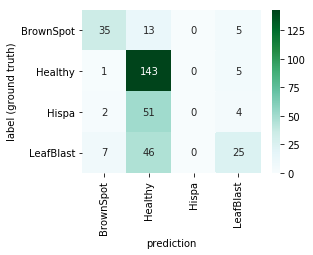

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 79	TRAIN	Loss: 0.85	Correct: 1865/3018(61.8%)
		VALID.:	Loss: 0.74	Correct: 215/337(63.8%)
----------------------------------------


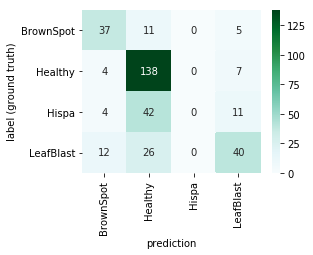

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 80	TRAIN	Loss: 1.11	Correct: 1895/3018(62.79%)
		VALID.:	Loss: 0.91	Correct: 213/337(63.2%)
----------------------------------------


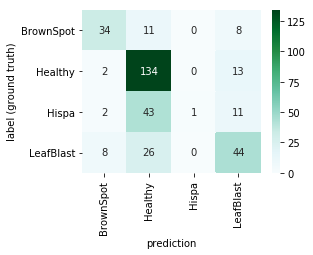

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 81	TRAIN	Loss: 0.88	Correct: 1853/3018(61.4%)
		VALID.:	Loss: 0.85	Correct: 225/337(66.77%)
----------------------------------------


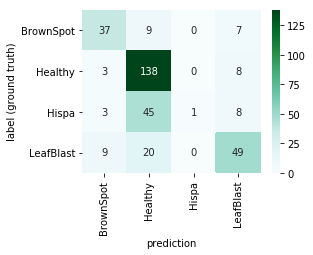

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 82	TRAIN	Loss: 1.37	Correct: 1771/3018(58.68%)
		VALID.:	Loss: 0.89	Correct: 210/337(62.31%)
----------------------------------------


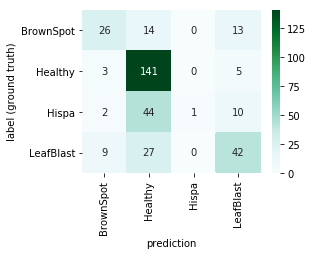

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 83	TRAIN	Loss: 0.81	Correct: 1786/3018(59.18%)
		VALID.:	Loss: 0.99	Correct: 214/337(63.5%)
----------------------------------------


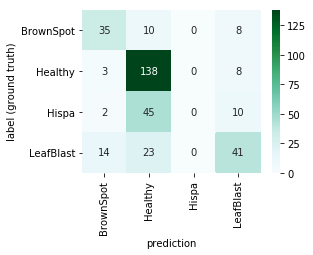

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 84	TRAIN	Loss: 0.93	Correct: 1829/3018(60.6%)
		VALID.:	Loss: 0.82	Correct: 215/337(63.8%)
----------------------------------------


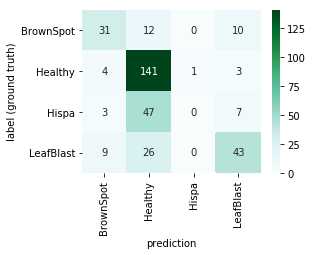

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 85	TRAIN	Loss: 0.92	Correct: 1847/3018(61.2%)
		VALID.:	Loss: 0.73	Correct: 224/337(66.47%)
----------------------------------------


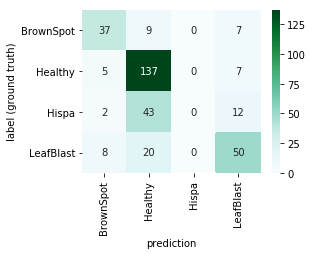

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 86	TRAIN	Loss: 0.92	Correct: 1787/3018(59.21%)
		VALID.:	Loss: 0.98	Correct: 208/337(61.72%)
----------------------------------------


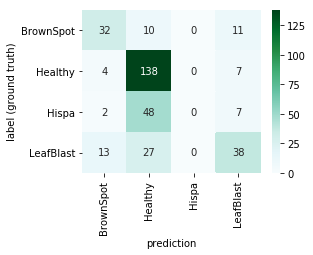

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 87	TRAIN	Loss: 0.89	Correct: 1852/3018(61.37%)
		VALID.:	Loss: 0.93	Correct: 213/337(63.2%)
----------------------------------------


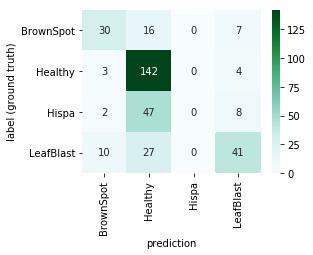

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 88	TRAIN	Loss: 0.9	Correct: 1877/3018(62.19%)
		VALID.:	Loss: 0.93	Correct: 222/337(65.88%)
----------------------------------------


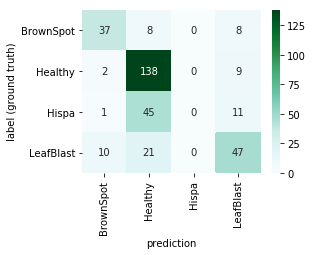

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 89	TRAIN	Loss: 1.32	Correct: 1897/3018(62.86%)
		VALID.:	Loss: 0.85	Correct: 224/337(66.47%)
----------------------------------------


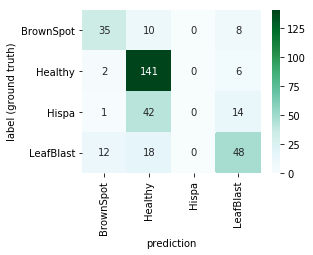

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 90	TRAIN	Loss: 0.74	Correct: 1907/3018(63.19%)
		VALID.:	Loss: 0.87	Correct: 221/337(65.58%)
----------------------------------------


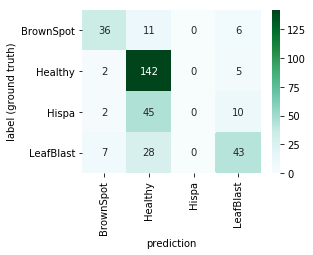

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 91	TRAIN	Loss: 1.32	Correct: 1899/3018(62.92%)
		VALID.:	Loss: 0.73	Correct: 222/337(65.88%)
----------------------------------------


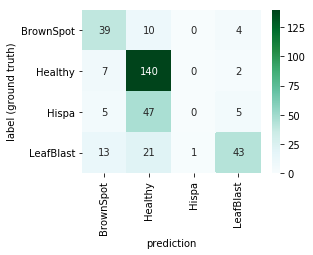

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 92	TRAIN	Loss: 0.78	Correct: 1912/3018(63.35%)
		VALID.:	Loss: 0.94	Correct: 225/337(66.77%)
----------------------------------------


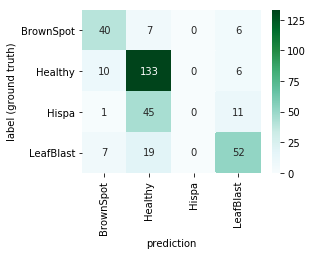

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 93	TRAIN	Loss: 1.08	Correct: 1921/3018(63.65%)
		VALID.:	Loss: 0.89	Correct: 227/337(67.36%)
----------------------------------------


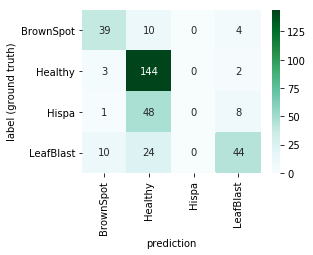

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 94	TRAIN	Loss: 1.16	Correct: 1918/3018(63.55%)
		VALID.:	Loss: 0.79	Correct: 216/337(64.09%)
----------------------------------------


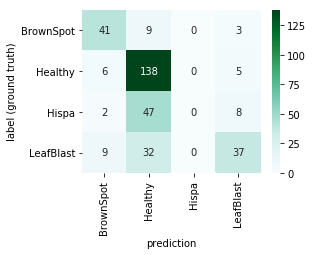

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 95	TRAIN	Loss: 1.55	Correct: 1919/3018(63.59%)
		VALID.:	Loss: 0.83	Correct: 231/337(68.55%)
----------------------------------------


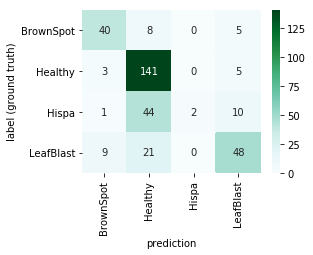

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 96	TRAIN	Loss: 0.73	Correct: 1929/3018(63.92%)
		VALID.:	Loss: 0.95	Correct: 222/337(65.88%)
----------------------------------------


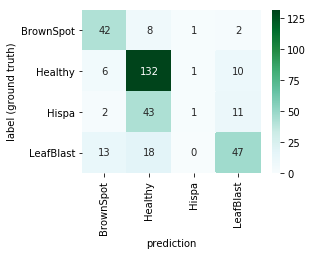

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 97	TRAIN	Loss: 0.84	Correct: 1890/3018(62.62%)
		VALID.:	Loss: 0.65	Correct: 221/337(65.58%)
----------------------------------------


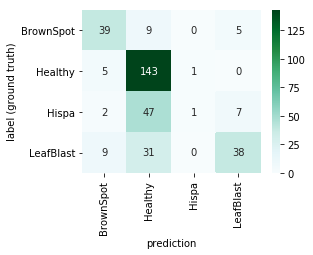

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 98	TRAIN	Loss: 0.73	Correct: 1919/3018(63.59%)
		VALID.:	Loss: 0.68	Correct: 230/337(68.25%)
----------------------------------------


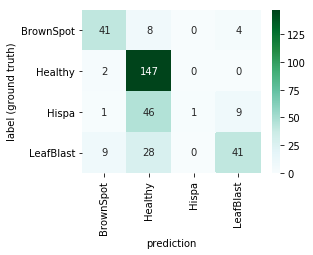

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 99	TRAIN	Loss: 1.56	Correct: 1825/3018(60.47%)
		VALID.:	Loss: 1.12	Correct: 221/337(65.58%)
----------------------------------------


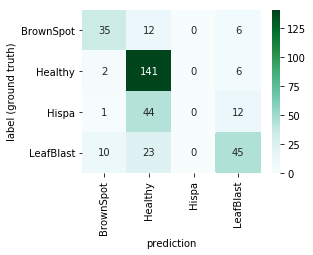

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 100	TRAIN	Loss: 0.55	Correct: 1875/3018(62.13%)
		VALID.:	Loss: 0.94	Correct: 216/337(64.09%)
----------------------------------------


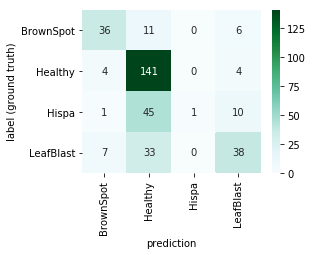

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 101	TRAIN	Loss: 1.17	Correct: 1883/3018(62.39%)
		VALID.:	Loss: 0.92	Correct: 231/337(68.55%)
----------------------------------------


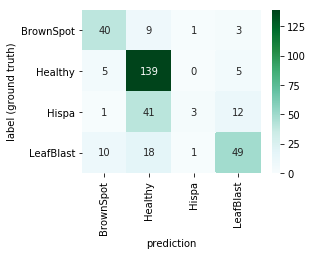

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 102	TRAIN	Loss: 0.83	Correct: 1920/3018(63.62%)
		VALID.:	Loss: 0.98	Correct: 231/337(68.55%)
----------------------------------------


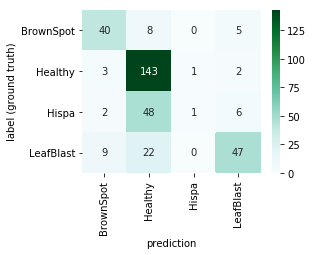

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 103	TRAIN	Loss: 0.68	Correct: 1946/3018(64.48%)
		VALID.:	Loss: 0.75	Correct: 230/337(68.25%)
----------------------------------------


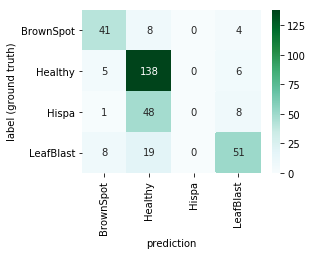

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 104	TRAIN	Loss: 1.09	Correct: 1922/3018(63.68%)
		VALID.:	Loss: 0.69	Correct: 213/337(63.2%)
----------------------------------------


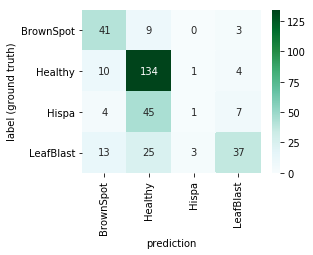

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 105	TRAIN	Loss: 0.95	Correct: 1940/3018(64.28%)
		VALID.:	Loss: 0.8	Correct: 228/337(67.66%)
----------------------------------------


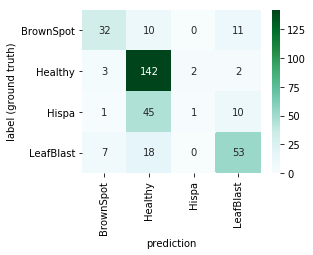

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 106	TRAIN	Loss: 1.03	Correct: 1927/3018(63.85%)
		VALID.:	Loss: 0.93	Correct: 215/337(63.8%)
----------------------------------------


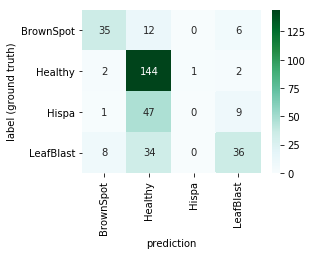

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 107	TRAIN	Loss: 0.76	Correct: 1948/3018(64.55%)
		VALID.:	Loss: 0.81	Correct: 222/337(65.88%)
----------------------------------------


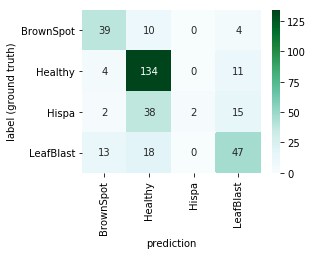

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 108	TRAIN	Loss: 0.89	Correct: 1961/3018(64.98%)
		VALID.:	Loss: 1.04	Correct: 223/337(66.17%)
----------------------------------------


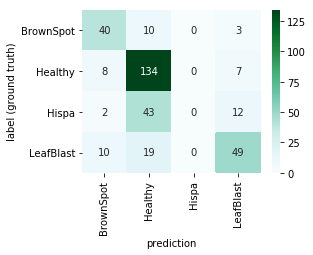

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 109	TRAIN	Loss: 0.91	Correct: 1946/3018(64.48%)
		VALID.:	Loss: 1.05	Correct: 231/337(68.55%)
----------------------------------------


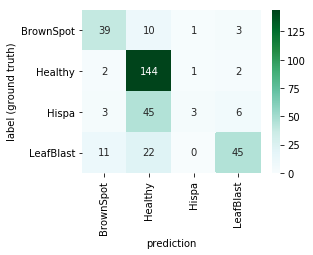

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 110	TRAIN	Loss: 1.37	Correct: 1954/3018(64.74%)
		VALID.:	Loss: 0.84	Correct: 233/337(69.14%)
----------------------------------------


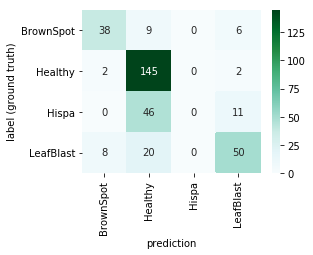

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 111	TRAIN	Loss: 0.69	Correct: 1937/3018(64.18%)
		VALID.:	Loss: 0.91	Correct: 229/337(67.95%)
----------------------------------------


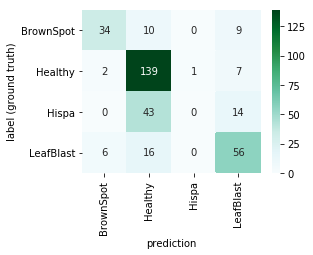

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 112	TRAIN	Loss: 0.77	Correct: 1954/3018(64.74%)
		VALID.:	Loss: 0.72	Correct: 229/337(67.95%)
----------------------------------------


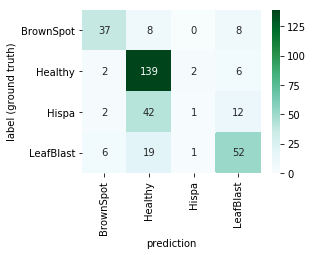

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 113	TRAIN	Loss: 0.92	Correct: 1941/3018(64.31%)
		VALID.:	Loss: 0.81	Correct: 235/337(69.73%)
----------------------------------------


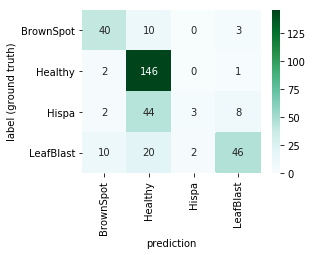

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 114	TRAIN	Loss: 0.62	Correct: 1928/3018(63.88%)
		VALID.:	Loss: 0.87	Correct: 214/337(63.5%)
----------------------------------------


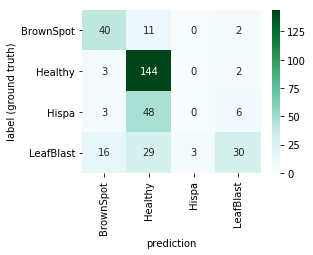

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 115	TRAIN	Loss: 1.03	Correct: 1926/3018(63.82%)
		VALID.:	Loss: 0.97	Correct: 220/337(65.28%)
----------------------------------------


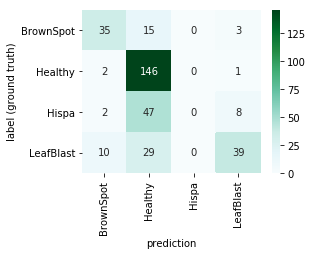

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 116	TRAIN	Loss: 0.89	Correct: 1930/3018(63.95%)
		VALID.:	Loss: 0.9	Correct: 229/337(67.95%)
----------------------------------------


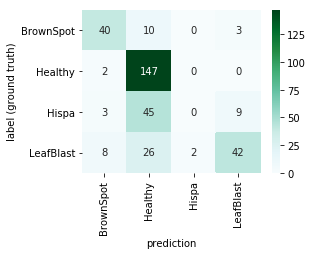

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 117	TRAIN	Loss: 1.02	Correct: 1951/3018(64.65%)
		VALID.:	Loss: 0.72	Correct: 228/337(67.66%)
----------------------------------------


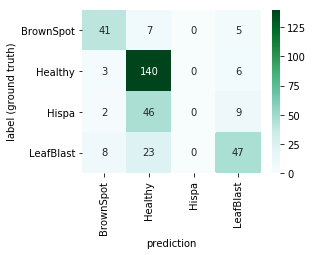

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 118	TRAIN	Loss: 0.81	Correct: 1939/3018(64.25%)
		VALID.:	Loss: 1.18	Correct: 224/337(66.47%)
----------------------------------------


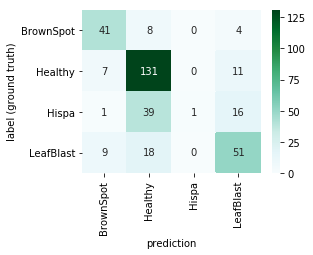

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 119	TRAIN	Loss: 0.83	Correct: 1950/3018(64.61%)
		VALID.:	Loss: 0.83	Correct: 228/337(67.66%)
----------------------------------------


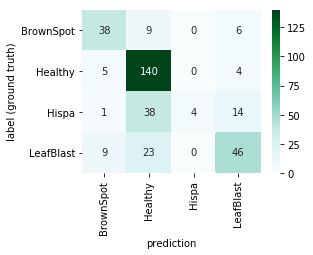

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 120	TRAIN	Loss: 1.29	Correct: 1940/3018(64.28%)
		VALID.:	Loss: 0.76	Correct: 230/337(68.25%)
----------------------------------------


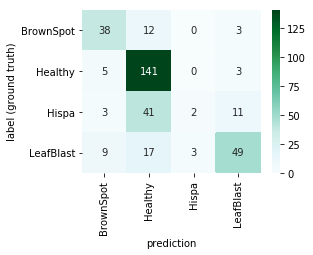

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 121	TRAIN	Loss: 0.65	Correct: 1970/3018(65.28%)
		VALID.:	Loss: 1.0	Correct: 232/337(68.84%)
----------------------------------------


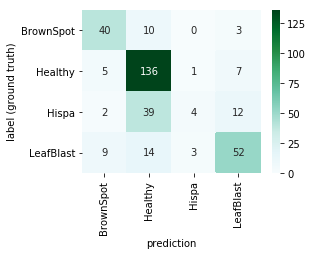

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 122	TRAIN	Loss: 1.16	Correct: 1946/3018(64.48%)
		VALID.:	Loss: 0.88	Correct: 233/337(69.14%)
----------------------------------------


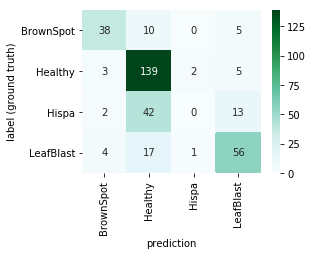

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 123	TRAIN	Loss: 0.95	Correct: 1977/3018(65.51%)
		VALID.:	Loss: 0.85	Correct: 221/337(65.58%)
----------------------------------------


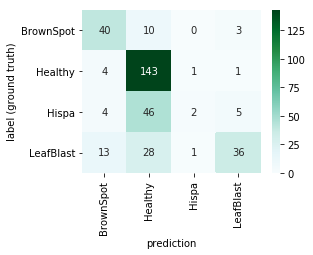

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 124	TRAIN	Loss: 0.98	Correct: 1983/3018(65.71%)
		VALID.:	Loss: 0.71	Correct: 231/337(68.55%)
----------------------------------------


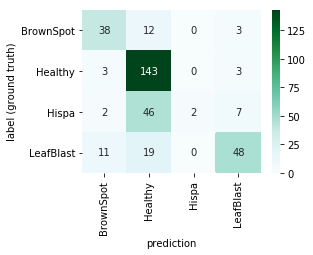

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 125	TRAIN	Loss: 1.04	Correct: 1956/3018(64.81%)
		VALID.:	Loss: 0.64	Correct: 236/337(70.03%)
----------------------------------------


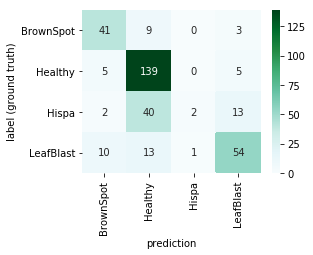

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 126	TRAIN	Loss: 1.17	Correct: 1973/3018(65.37%)
		VALID.:	Loss: 1.13	Correct: 221/337(65.58%)
----------------------------------------


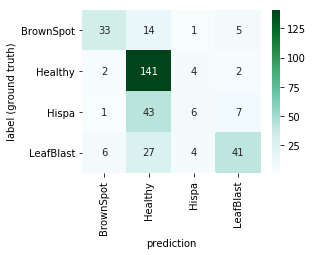

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 127	TRAIN	Loss: 0.58	Correct: 1948/3018(64.55%)
		VALID.:	Loss: 0.84	Correct: 232/337(68.84%)
----------------------------------------


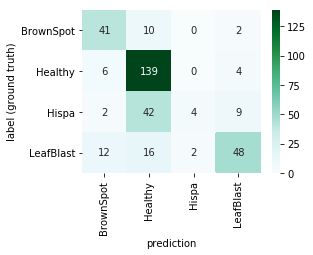

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 128	TRAIN	Loss: 1.06	Correct: 1953/3018(64.71%)
		VALID.:	Loss: 0.66	Correct: 239/337(70.92%)
----------------------------------------


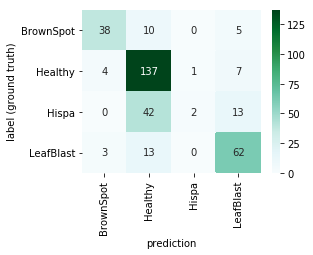

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 129	TRAIN	Loss: 0.33	Correct: 1963/3018(65.04%)
		VALID.:	Loss: 0.99	Correct: 226/337(67.06%)
----------------------------------------


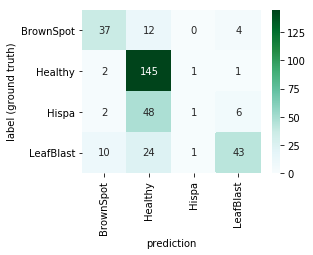

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 130	TRAIN	Loss: 0.79	Correct: 1980/3018(65.61%)
		VALID.:	Loss: 0.93	Correct: 234/337(69.44%)
----------------------------------------


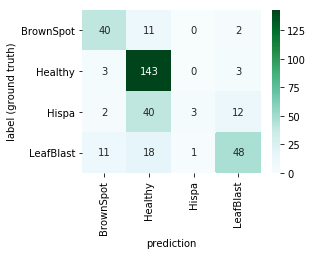

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 131	TRAIN	Loss: 1.97	Correct: 1968/3018(65.21%)
		VALID.:	Loss: 1.0	Correct: 227/337(67.36%)
----------------------------------------


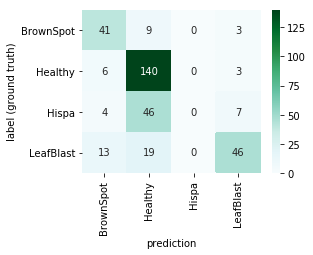

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 132	TRAIN	Loss: 0.83	Correct: 1949/3018(64.58%)
		VALID.:	Loss: 1.07	Correct: 232/337(68.84%)
----------------------------------------


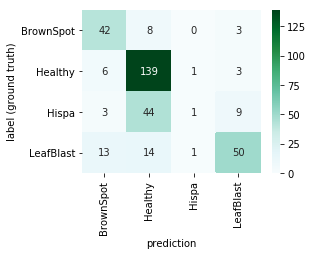

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 133	TRAIN	Loss: 0.61	Correct: 1948/3018(64.55%)
		VALID.:	Loss: 0.8	Correct: 231/337(68.55%)
----------------------------------------


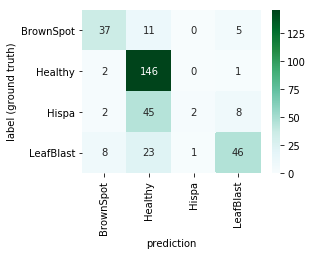

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 134	TRAIN	Loss: 0.6	Correct: 1951/3018(64.65%)
		VALID.:	Loss: 0.91	Correct: 231/337(68.55%)
----------------------------------------


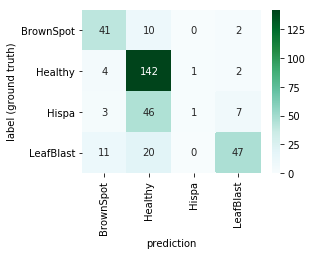

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 135	TRAIN	Loss: 0.37	Correct: 1948/3018(64.55%)
		VALID.:	Loss: 0.84	Correct: 224/337(66.47%)
----------------------------------------


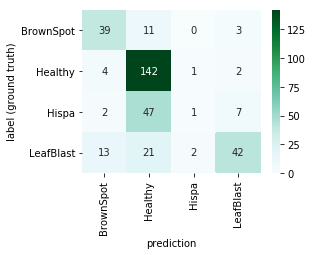

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 136	TRAIN	Loss: 0.74	Correct: 1967/3018(65.18%)
		VALID.:	Loss: 0.95	Correct: 230/337(68.25%)
----------------------------------------


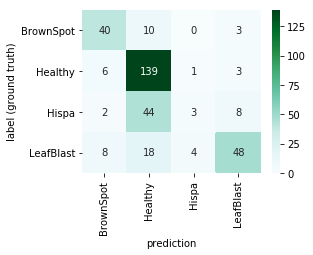

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 137	TRAIN	Loss: 0.92	Correct: 1968/3018(65.21%)
		VALID.:	Loss: 0.72	Correct: 237/337(70.33%)
----------------------------------------


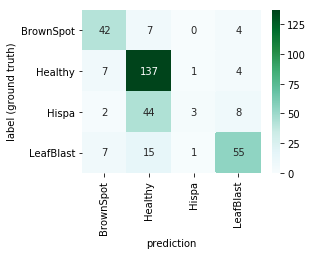

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 138	TRAIN	Loss: 0.66	Correct: 1948/3018(64.55%)
		VALID.:	Loss: 0.64	Correct: 235/337(69.73%)
----------------------------------------


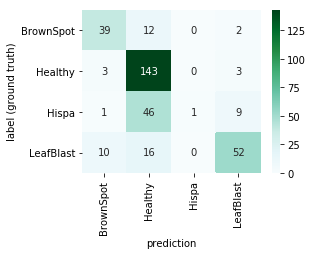

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 139	TRAIN	Loss: 0.98	Correct: 1939/3018(64.25%)
		VALID.:	Loss: 0.66	Correct: 230/337(68.25%)
----------------------------------------


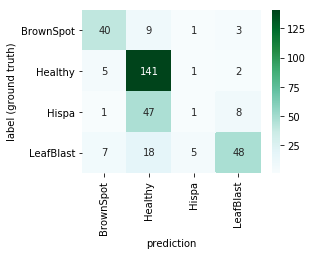

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 140	TRAIN	Loss: 1.15	Correct: 1982/3018(65.67%)
		VALID.:	Loss: 0.81	Correct: 235/337(69.73%)
----------------------------------------


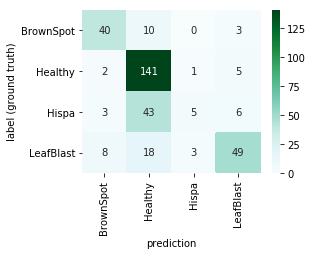

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 141	TRAIN	Loss: 0.96	Correct: 1975/3018(65.44%)
		VALID.:	Loss: 0.93	Correct: 236/337(70.03%)
----------------------------------------


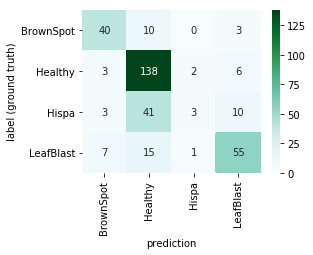

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 142	TRAIN	Loss: 1.44	Correct: 1938/3018(64.21%)
		VALID.:	Loss: 0.97	Correct: 226/337(67.06%)
----------------------------------------


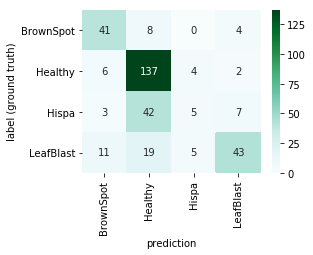

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 143	TRAIN	Loss: 0.84	Correct: 1962/3018(65.01%)
		VALID.:	Loss: 0.76	Correct: 242/337(71.81%)
----------------------------------------


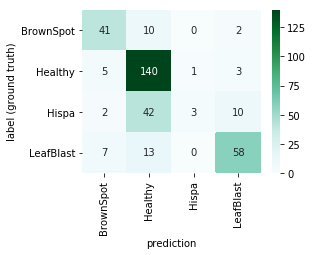

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 144	TRAIN	Loss: 1.12	Correct: 1971/3018(65.31%)
		VALID.:	Loss: 0.76	Correct: 233/337(69.14%)
----------------------------------------


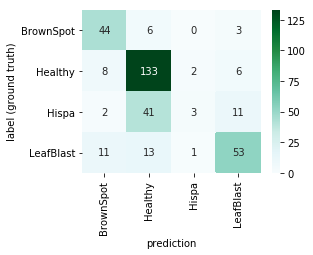

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 145	TRAIN	Loss: 0.92	Correct: 1987/3018(65.84%)
		VALID.:	Loss: 0.81	Correct: 230/337(68.25%)
----------------------------------------


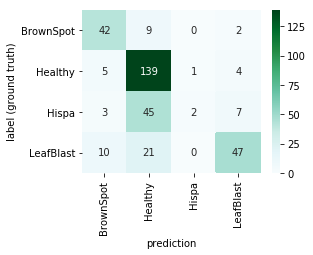

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 146	TRAIN	Loss: 0.91	Correct: 1982/3018(65.67%)
		VALID.:	Loss: 0.73	Correct: 232/337(68.84%)
----------------------------------------


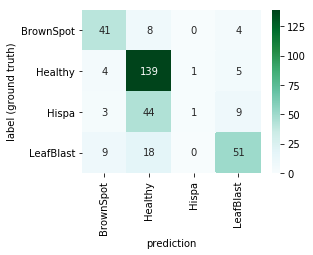

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 147	TRAIN	Loss: 0.87	Correct: 1986/3018(65.81%)
		VALID.:	Loss: 0.56	Correct: 230/337(68.25%)
----------------------------------------


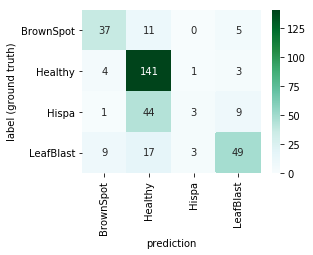

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 148	TRAIN	Loss: 0.7	Correct: 1957/3018(64.84%)
		VALID.:	Loss: 1.14	Correct: 236/337(70.03%)
----------------------------------------


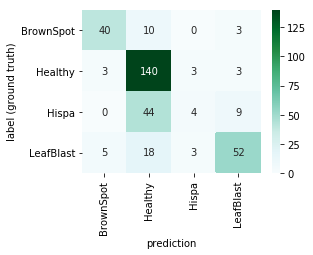

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 149	TRAIN	Loss: 0.71	Correct: 1990/3018(65.94%)
		VALID.:	Loss: 0.78	Correct: 232/337(68.84%)
----------------------------------------


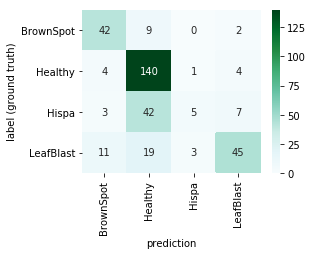

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 150	TRAIN	Loss: 1.33	Correct: 1984/3018(65.74%)
		VALID.:	Loss: 0.84	Correct: 232/337(68.84%)
----------------------------------------


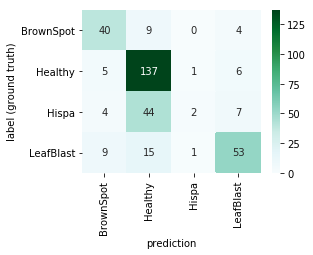

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 151	TRAIN	Loss: 0.48	Correct: 1948/3018(64.55%)
		VALID.:	Loss: 1.03	Correct: 224/337(66.47%)
----------------------------------------


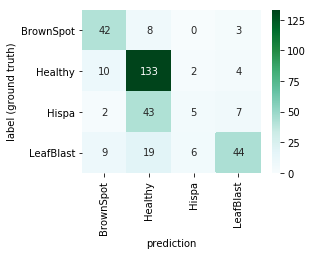

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 152	TRAIN	Loss: 0.79	Correct: 1949/3018(64.58%)
		VALID.:	Loss: 0.89	Correct: 231/337(68.55%)
----------------------------------------


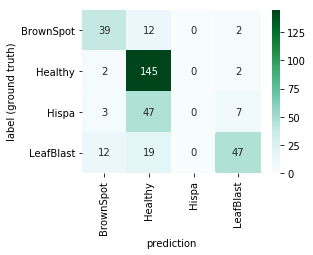

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 153	TRAIN	Loss: 0.76	Correct: 1958/3018(64.88%)
		VALID.:	Loss: 0.57	Correct: 230/337(68.25%)
----------------------------------------


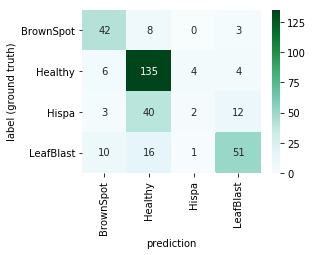

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 154	TRAIN	Loss: 0.8	Correct: 1978/3018(65.54%)
		VALID.:	Loss: 0.84	Correct: 231/337(68.55%)
----------------------------------------


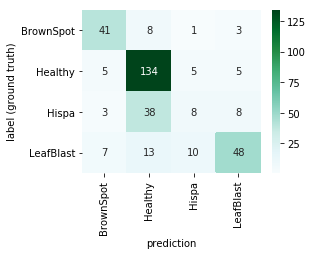

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 155	TRAIN	Loss: 0.68	Correct: 1976/3018(65.47%)
		VALID.:	Loss: 0.89	Correct: 229/337(67.95%)
----------------------------------------


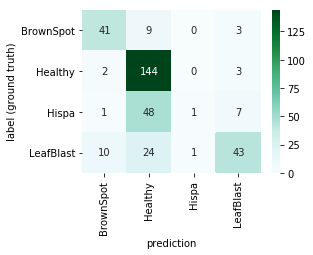

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 156	TRAIN	Loss: 0.76	Correct: 1953/3018(64.71%)
		VALID.:	Loss: 1.07	Correct: 229/337(67.95%)
----------------------------------------


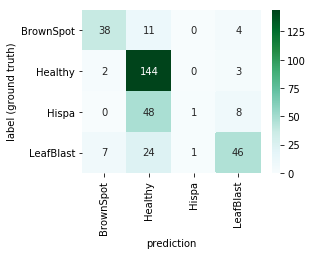

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 157	TRAIN	Loss: 1.27	Correct: 1966/3018(65.14%)
		VALID.:	Loss: 0.88	Correct: 236/337(70.03%)
----------------------------------------


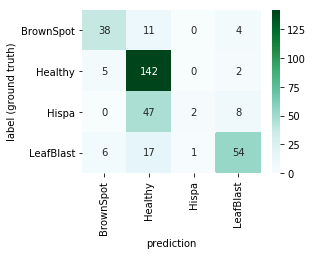

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 158	TRAIN	Loss: 0.82	Correct: 1982/3018(65.67%)
		VALID.:	Loss: 0.84	Correct: 228/337(67.66%)
----------------------------------------


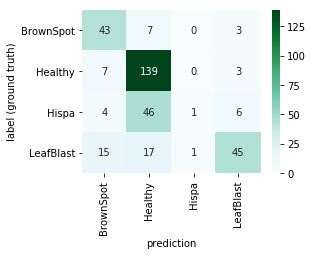

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 159	TRAIN	Loss: 0.61	Correct: 1974/3018(65.41%)
		VALID.:	Loss: 0.95	Correct: 226/337(67.06%)
----------------------------------------


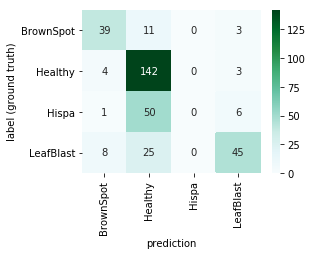

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 160	TRAIN	Loss: 0.76	Correct: 1975/3018(65.44%)
		VALID.:	Loss: 0.68	Correct: 242/337(71.81%)
----------------------------------------


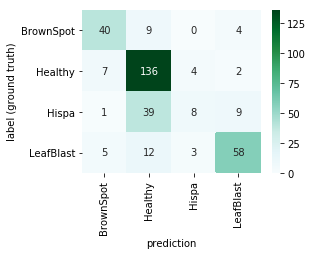

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 161	TRAIN	Loss: 0.84	Correct: 1965/3018(65.11%)
		VALID.:	Loss: 0.94	Correct: 220/337(65.28%)
----------------------------------------


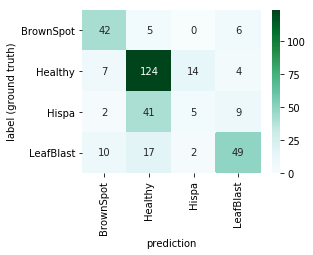

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 162	TRAIN	Loss: 0.95	Correct: 1953/3018(64.71%)
		VALID.:	Loss: 0.98	Correct: 216/337(64.09%)
----------------------------------------


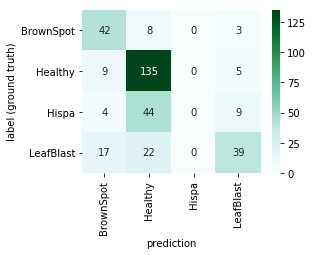

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 163	TRAIN	Loss: 0.59	Correct: 1973/3018(65.37%)
		VALID.:	Loss: 0.77	Correct: 232/337(68.84%)
----------------------------------------


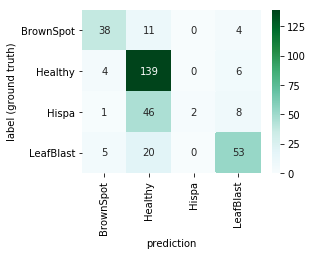

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 164	TRAIN	Loss: 1.01	Correct: 1986/3018(65.81%)
		VALID.:	Loss: 0.62	Correct: 231/337(68.55%)
----------------------------------------


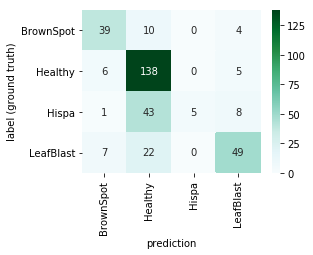

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 165	TRAIN	Loss: 0.95	Correct: 1975/3018(65.44%)
		VALID.:	Loss: 1.03	Correct: 224/337(66.47%)
----------------------------------------


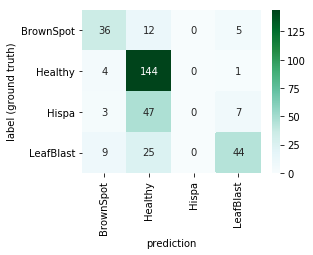

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 166	TRAIN	Loss: 0.52	Correct: 1984/3018(65.74%)
		VALID.:	Loss: 0.77	Correct: 235/337(69.73%)
----------------------------------------


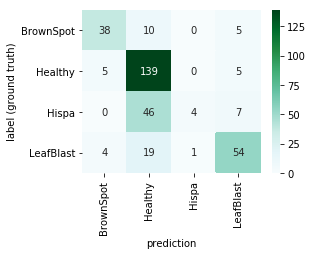

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 167	TRAIN	Loss: 0.58	Correct: 2001/3018(66.3%)
		VALID.:	Loss: 0.75	Correct: 235/337(69.73%)
----------------------------------------


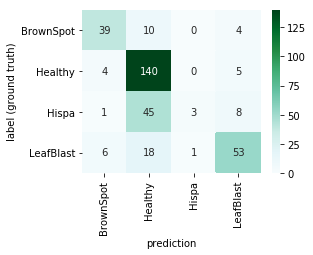

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 168	TRAIN	Loss: 0.51	Correct: 1989/3018(65.9%)
		VALID.:	Loss: 0.88	Correct: 232/337(68.84%)
----------------------------------------


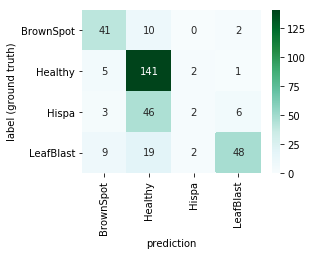

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 169	TRAIN	Loss: 1.29	Correct: 1976/3018(65.47%)
		VALID.:	Loss: 0.87	Correct: 230/337(68.25%)
----------------------------------------


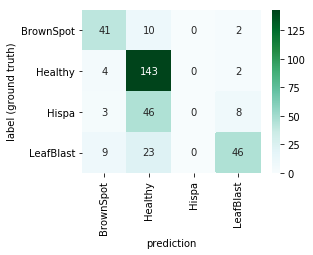

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 170	TRAIN	Loss: 1.92	Correct: 2003/3018(66.37%)
		VALID.:	Loss: 0.73	Correct: 227/337(67.36%)
----------------------------------------


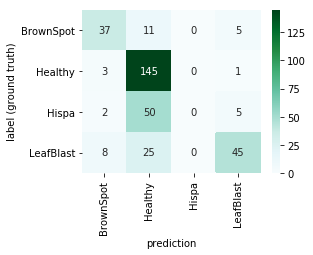

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 171	TRAIN	Loss: 1.38	Correct: 1958/3018(64.88%)
		VALID.:	Loss: 0.6	Correct: 227/337(67.36%)
----------------------------------------


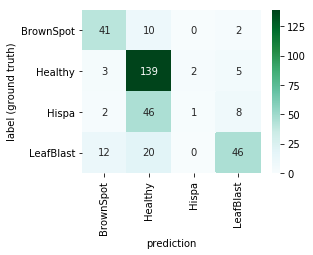

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 172	TRAIN	Loss: 0.79	Correct: 1990/3018(65.94%)
		VALID.:	Loss: 0.94	Correct: 227/337(67.36%)
----------------------------------------


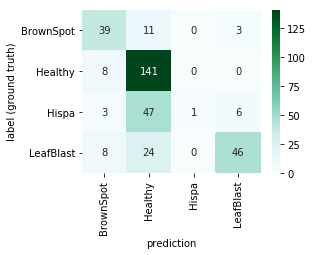

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 173	TRAIN	Loss: 0.38	Correct: 1978/3018(65.54%)
		VALID.:	Loss: 0.93	Correct: 221/337(65.58%)
----------------------------------------


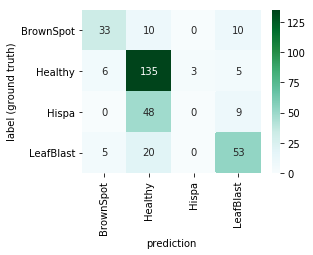

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 174	TRAIN	Loss: 0.84	Correct: 1992/3018(66.0%)
		VALID.:	Loss: 1.07	Correct: 227/337(67.36%)
----------------------------------------


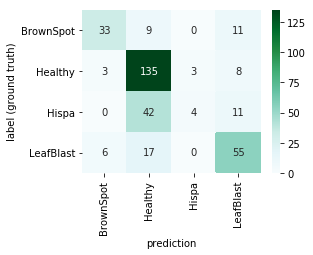

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 175	TRAIN	Loss: 1.12	Correct: 1988/3018(65.87%)
		VALID.:	Loss: 1.02	Correct: 224/337(66.47%)
----------------------------------------


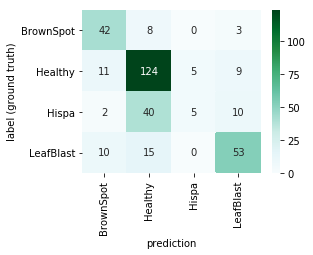

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 176	TRAIN	Loss: 0.64	Correct: 1971/3018(65.31%)
		VALID.:	Loss: 0.62	Correct: 239/337(70.92%)
----------------------------------------


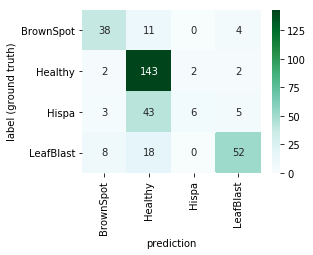

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 177	TRAIN	Loss: 1.26	Correct: 1952/3018(64.68%)
		VALID.:	Loss: 0.96	Correct: 233/337(69.14%)
----------------------------------------


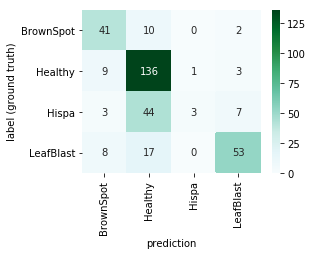

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 178	TRAIN	Loss: 1.59	Correct: 1997/3018(66.17%)
		VALID.:	Loss: 0.69	Correct: 234/337(69.44%)
----------------------------------------


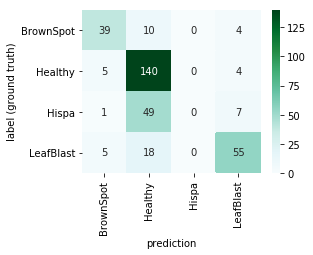

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 179	TRAIN	Loss: 1.67	Correct: 2000/3018(66.27%)
		VALID.:	Loss: 0.85	Correct: 233/337(69.14%)
----------------------------------------


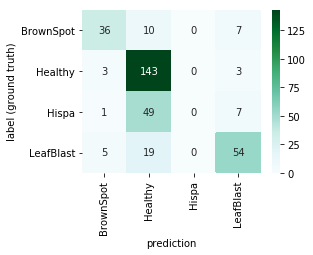

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 180	TRAIN	Loss: 0.56	Correct: 1991/3018(65.97%)
		VALID.:	Loss: 0.68	Correct: 231/337(68.55%)
----------------------------------------


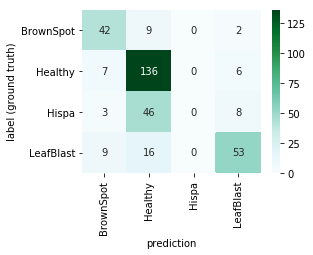

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 181	TRAIN	Loss: 0.81	Correct: 2015/3018(66.77%)
		VALID.:	Loss: 0.76	Correct: 231/337(68.55%)
----------------------------------------


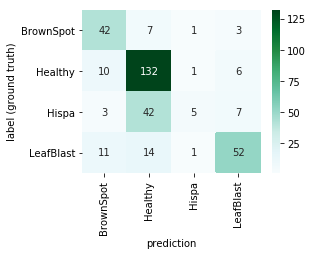

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 182	TRAIN	Loss: 1.09	Correct: 1995/3018(66.1%)
		VALID.:	Loss: 0.68	Correct: 232/337(68.84%)
----------------------------------------


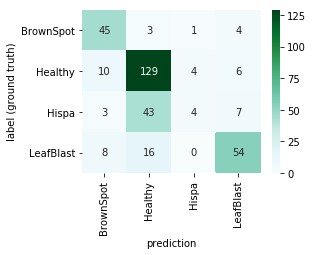

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 183	TRAIN	Loss: 0.83	Correct: 2007/3018(66.5%)
		VALID.:	Loss: 0.68	Correct: 237/337(70.33%)
----------------------------------------


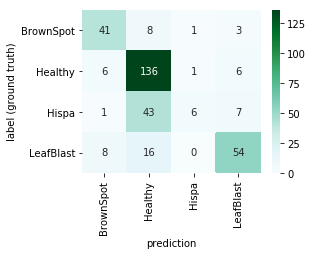

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 184	TRAIN	Loss: 0.54	Correct: 1984/3018(65.74%)
		VALID.:	Loss: 0.73	Correct: 235/337(69.73%)
----------------------------------------


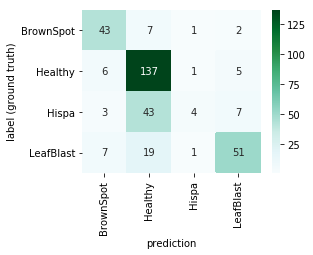

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 185	TRAIN	Loss: 0.69	Correct: 1978/3018(65.54%)
		VALID.:	Loss: 0.61	Correct: 234/337(69.44%)
----------------------------------------


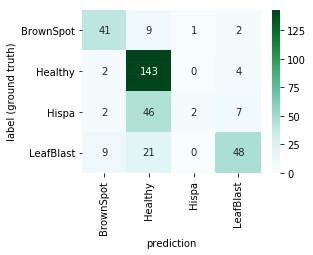

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 186	TRAIN	Loss: 0.53	Correct: 1976/3018(65.47%)
		VALID.:	Loss: 0.96	Correct: 231/337(68.55%)
----------------------------------------


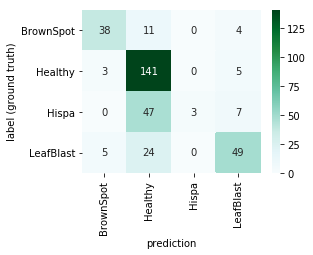

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 187	TRAIN	Loss: 0.66	Correct: 1957/3018(64.84%)
		VALID.:	Loss: 0.76	Correct: 230/337(68.25%)
----------------------------------------


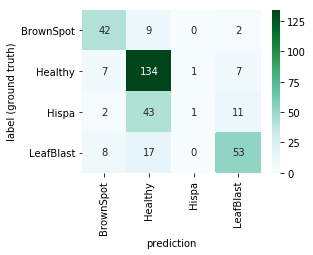

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 188	TRAIN	Loss: 0.46	Correct: 2013/3018(66.7%)
		VALID.:	Loss: 0.79	Correct: 237/337(70.33%)
----------------------------------------


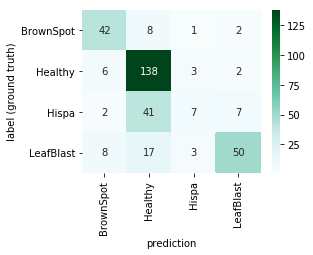

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 189	TRAIN	Loss: 0.73	Correct: 1977/3018(65.51%)
		VALID.:	Loss: 0.71	Correct: 237/337(70.33%)
----------------------------------------


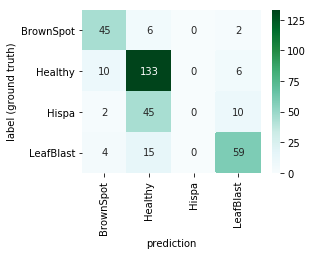

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 190	TRAIN	Loss: 0.61	Correct: 1974/3018(65.41%)
		VALID.:	Loss: 0.84	Correct: 232/337(68.84%)
----------------------------------------


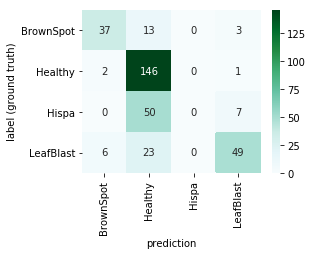

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 191	TRAIN	Loss: 0.81	Correct: 2004/3018(66.4%)
		VALID.:	Loss: 0.75	Correct: 230/337(68.25%)
----------------------------------------


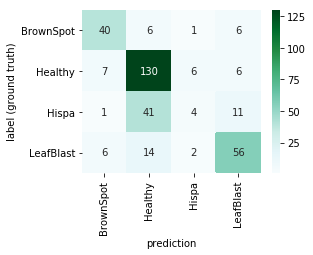

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 192	TRAIN	Loss: 1.06	Correct: 1981/3018(65.64%)
		VALID.:	Loss: 0.84	Correct: 230/337(68.25%)
----------------------------------------


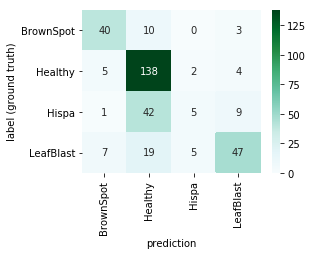

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 193	TRAIN	Loss: 1.93	Correct: 2003/3018(66.37%)
		VALID.:	Loss: 0.83	Correct: 230/337(68.25%)
----------------------------------------


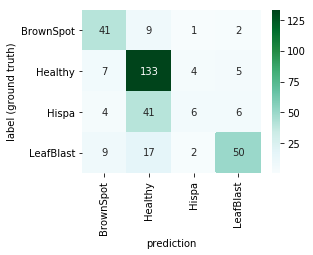

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 194	TRAIN	Loss: 0.24	Correct: 1984/3018(65.74%)
		VALID.:	Loss: 0.7	Correct: 220/337(65.28%)
----------------------------------------


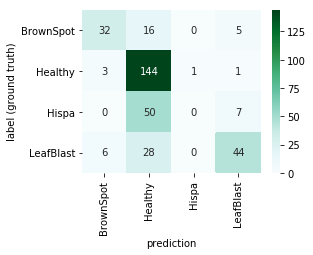

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 195	TRAIN	Loss: 0.89	Correct: 1994/3018(66.07%)
		VALID.:	Loss: 0.9	Correct: 224/337(66.47%)
----------------------------------------


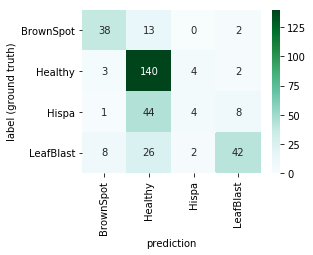

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 196	TRAIN	Loss: 0.4	Correct: 1972/3018(65.34%)
		VALID.:	Loss: 0.95	Correct: 239/337(70.92%)
----------------------------------------


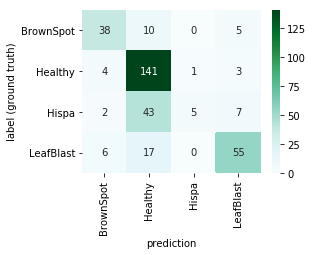

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 197	TRAIN	Loss: 1.01	Correct: 2008/3018(66.53%)
		VALID.:	Loss: 1.04	Correct: 236/337(70.03%)
----------------------------------------


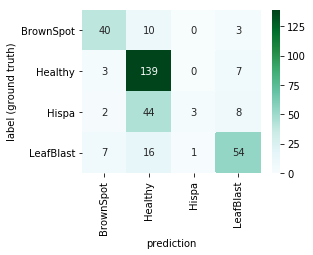

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 198	TRAIN	Loss: 1.29	Correct: 2023/3018(67.03%)
		VALID.:	Loss: 0.7	Correct: 233/337(69.14%)
----------------------------------------


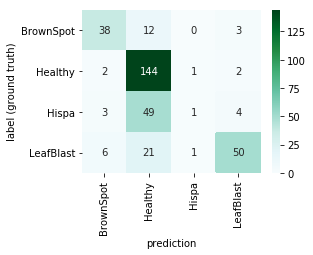

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 199	TRAIN	Loss: 1.92	Correct: 2015/3018(66.77%)
		VALID.:	Loss: 0.87	Correct: 229/337(67.95%)
----------------------------------------


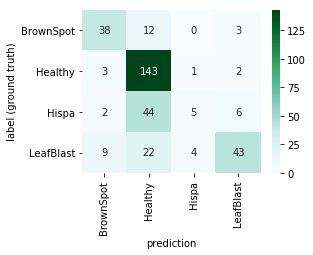

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 200	TRAIN	Loss: 0.53	Correct: 2004/3018(66.4%)
		VALID.:	Loss: 0.69	Correct: 235/337(69.73%)
----------------------------------------


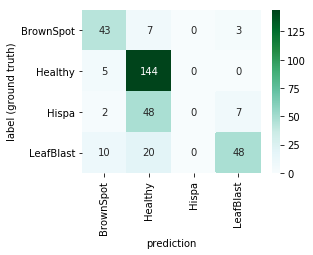

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 201	TRAIN	Loss: 1.06	Correct: 1984/3018(65.74%)
		VALID.:	Loss: 0.77	Correct: 242/337(71.81%)
----------------------------------------


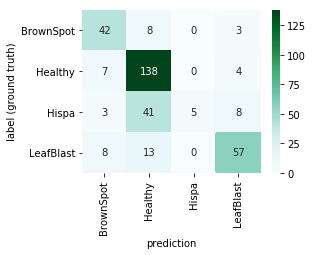

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 202	TRAIN	Loss: 1.66	Correct: 2000/3018(66.27%)
		VALID.:	Loss: 0.87	Correct: 238/337(70.62%)
----------------------------------------


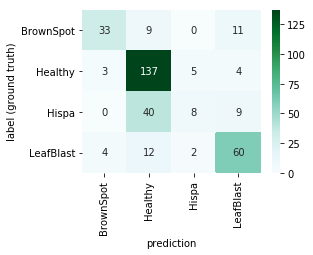

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 203	TRAIN	Loss: 0.74	Correct: 2003/3018(66.37%)
		VALID.:	Loss: 0.81	Correct: 235/337(69.73%)
----------------------------------------


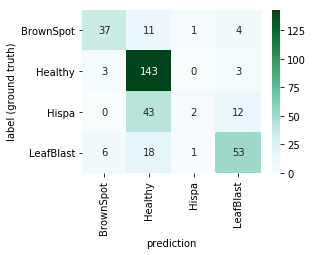

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 204	TRAIN	Loss: 0.75	Correct: 2014/3018(66.73%)
		VALID.:	Loss: 0.81	Correct: 231/337(68.55%)
----------------------------------------


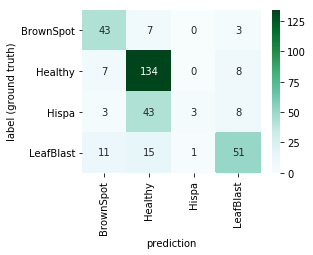

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 205	TRAIN	Loss: 0.72	Correct: 2000/3018(66.27%)
		VALID.:	Loss: 0.73	Correct: 231/337(68.55%)
----------------------------------------


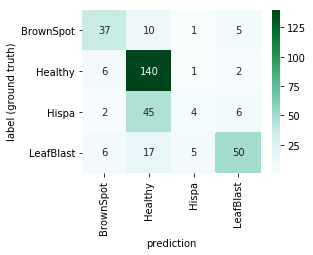

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 206	TRAIN	Loss: 0.85	Correct: 1999/3018(66.24%)
		VALID.:	Loss: 0.75	Correct: 237/337(70.33%)
----------------------------------------


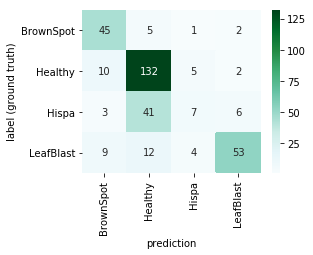

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 207	TRAIN	Loss: 0.62	Correct: 2004/3018(66.4%)
		VALID.:	Loss: 0.76	Correct: 236/337(70.03%)
----------------------------------------


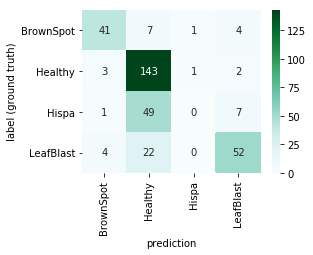

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 208	TRAIN	Loss: 0.48	Correct: 2010/3018(66.6%)
		VALID.:	Loss: 0.97	Correct: 237/337(70.33%)
----------------------------------------


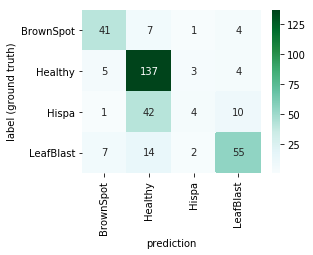

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 209	TRAIN	Loss: 0.63	Correct: 1982/3018(65.67%)
		VALID.:	Loss: 1.26	Correct: 212/337(62.91%)
----------------------------------------


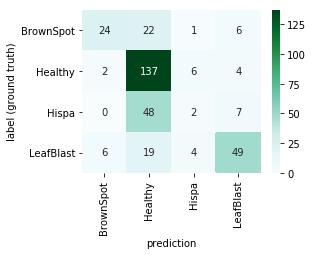

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 210	TRAIN	Loss: 1.02	Correct: 1987/3018(65.84%)
		VALID.:	Loss: 1.12	Correct: 222/337(65.88%)
----------------------------------------


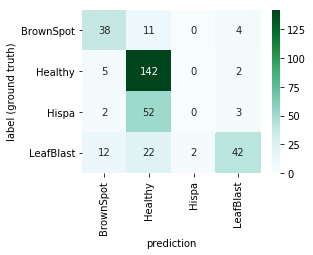

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 211	TRAIN	Loss: 0.98	Correct: 1998/3018(66.2%)
		VALID.:	Loss: 0.82	Correct: 236/337(70.03%)
----------------------------------------


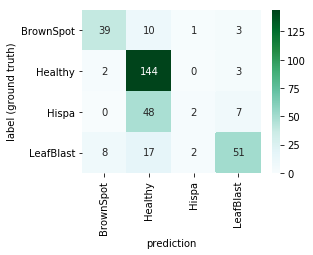

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 212	TRAIN	Loss: 1.56	Correct: 2010/3018(66.6%)
		VALID.:	Loss: 0.72	Correct: 235/337(69.73%)
----------------------------------------


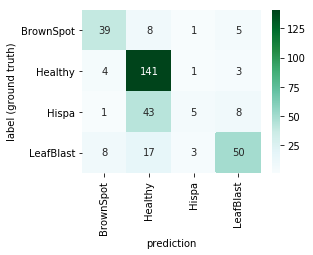

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 213	TRAIN	Loss: 0.72	Correct: 2023/3018(67.03%)
		VALID.:	Loss: 0.7	Correct: 232/337(68.84%)
----------------------------------------


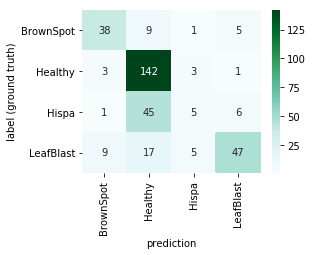

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 214	TRAIN	Loss: 0.55	Correct: 1987/3018(65.84%)
		VALID.:	Loss: 0.88	Correct: 232/337(68.84%)
----------------------------------------


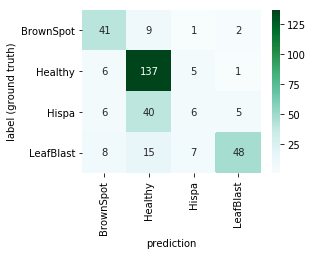

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 215	TRAIN	Loss: 1.2	Correct: 1993/3018(66.04%)
		VALID.:	Loss: 0.98	Correct: 236/337(70.03%)
----------------------------------------


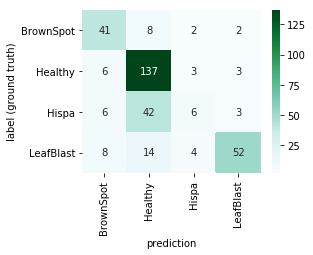

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 216	TRAIN	Loss: 1.05	Correct: 1988/3018(65.87%)
		VALID.:	Loss: 0.86	Correct: 235/337(69.73%)
----------------------------------------


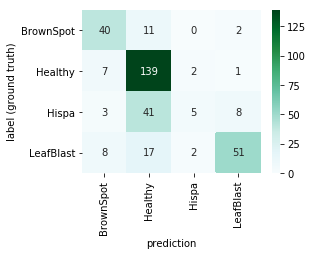

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 217	TRAIN	Loss: 0.75	Correct: 1975/3018(65.44%)
		VALID.:	Loss: 0.71	Correct: 238/337(70.62%)
----------------------------------------


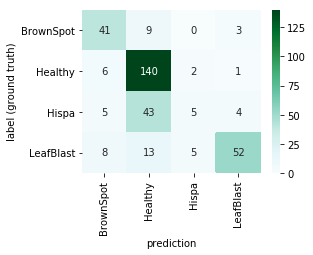

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 218	TRAIN	Loss: 0.64	Correct: 1975/3018(65.44%)
		VALID.:	Loss: 0.63	Correct: 230/337(68.25%)
----------------------------------------


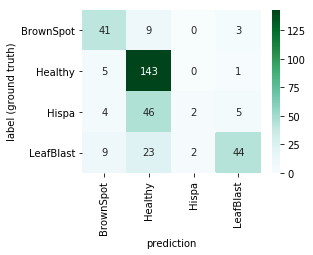

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 219	TRAIN	Loss: 0.86	Correct: 2010/3018(66.6%)
		VALID.:	Loss: 0.76	Correct: 236/337(70.03%)
----------------------------------------


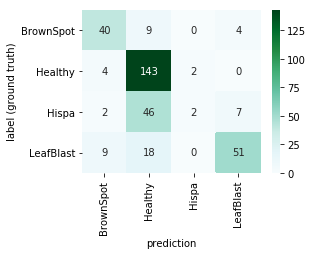

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 220	TRAIN	Loss: 1.33	Correct: 1993/3018(66.04%)
		VALID.:	Loss: 0.86	Correct: 233/337(69.14%)
----------------------------------------


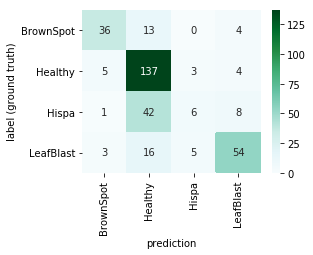

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 221	TRAIN	Loss: 1.05	Correct: 2002/3018(66.34%)
		VALID.:	Loss: 0.93	Correct: 238/337(70.62%)
----------------------------------------


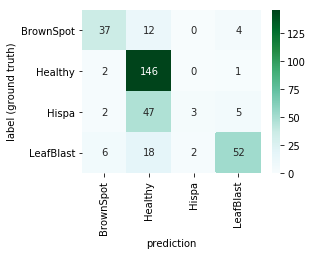

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 222	TRAIN	Loss: 0.72	Correct: 2014/3018(66.73%)
		VALID.:	Loss: 0.64	Correct: 238/337(70.62%)
----------------------------------------


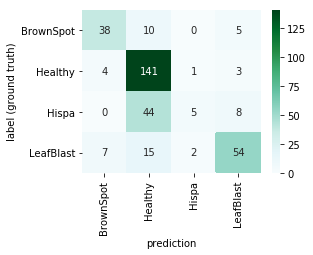

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 223	TRAIN	Loss: 0.56	Correct: 1985/3018(65.77%)
		VALID.:	Loss: 0.71	Correct: 234/337(69.44%)
----------------------------------------


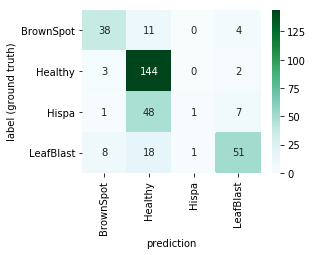

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 224	TRAIN	Loss: 1.47	Correct: 2023/3018(67.03%)
		VALID.:	Loss: 0.66	Correct: 236/337(70.03%)
----------------------------------------


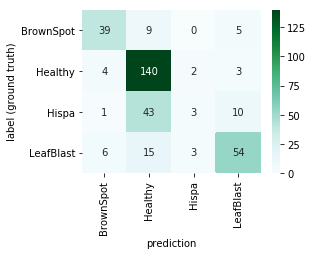

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 225	TRAIN	Loss: 1.06	Correct: 2039/3018(67.56%)
		VALID.:	Loss: 0.9	Correct: 226/337(67.06%)
----------------------------------------


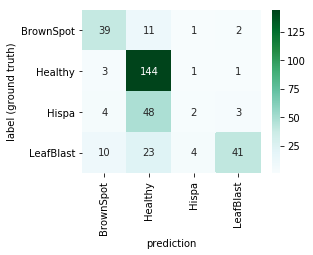

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 226	TRAIN	Loss: 0.52	Correct: 1997/3018(66.17%)
		VALID.:	Loss: 0.81	Correct: 229/337(67.95%)
----------------------------------------


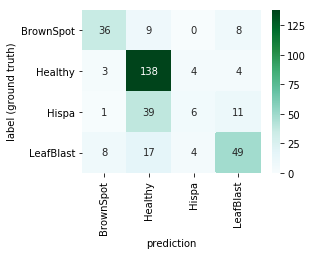

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 227	TRAIN	Loss: 0.78	Correct: 1989/3018(65.9%)
		VALID.:	Loss: 0.83	Correct: 234/337(69.44%)
----------------------------------------


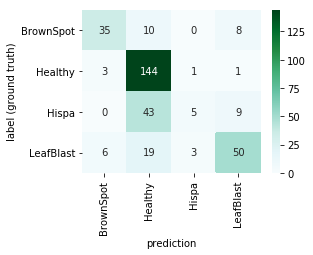

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 228	TRAIN	Loss: 0.75	Correct: 2016/3018(66.8%)
		VALID.:	Loss: 0.94	Correct: 239/337(70.92%)
----------------------------------------


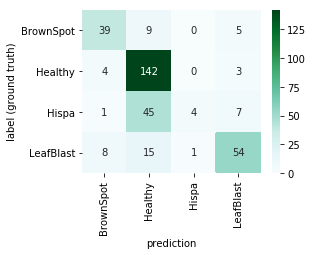

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 229	TRAIN	Loss: 0.38	Correct: 2015/3018(66.77%)
		VALID.:	Loss: 0.78	Correct: 238/337(70.62%)
----------------------------------------


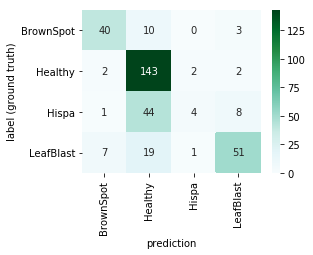

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 230	TRAIN	Loss: 0.63	Correct: 2030/3018(67.26%)
		VALID.:	Loss: 1.05	Correct: 241/337(71.51%)
----------------------------------------


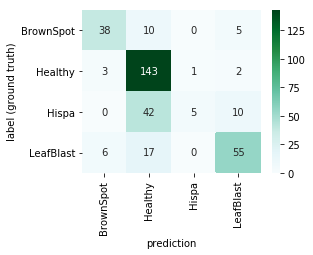

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 231	TRAIN	Loss: 0.8	Correct: 1991/3018(65.97%)
		VALID.:	Loss: 0.74	Correct: 236/337(70.03%)
----------------------------------------


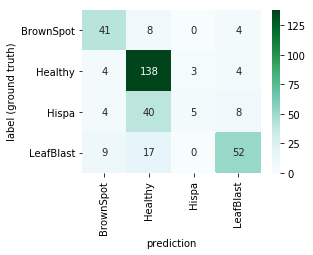

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 232	TRAIN	Loss: 0.72	Correct: 2000/3018(66.27%)
		VALID.:	Loss: 0.68	Correct: 234/337(69.44%)
----------------------------------------


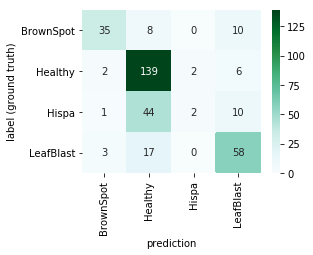

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 233	TRAIN	Loss: 0.9	Correct: 2005/3018(66.43%)
		VALID.:	Loss: 0.88	Correct: 238/337(70.62%)
----------------------------------------


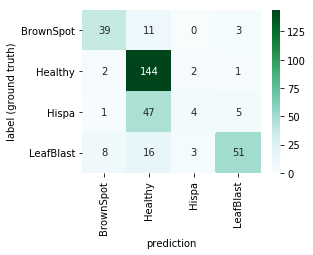

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 234	TRAIN	Loss: 0.65	Correct: 1982/3018(65.67%)
		VALID.:	Loss: 0.78	Correct: 235/337(69.73%)
----------------------------------------


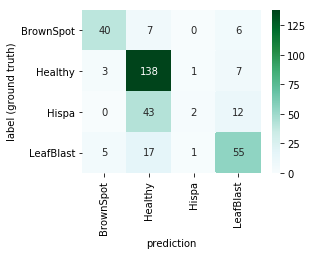

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 235	TRAIN	Loss: 0.91	Correct: 2014/3018(66.73%)
		VALID.:	Loss: 0.71	Correct: 226/337(67.06%)
----------------------------------------


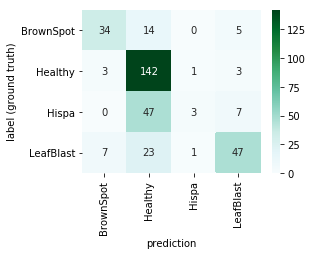

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 236	TRAIN	Loss: 0.39	Correct: 2000/3018(66.27%)
		VALID.:	Loss: 0.86	Correct: 239/337(70.92%)
----------------------------------------


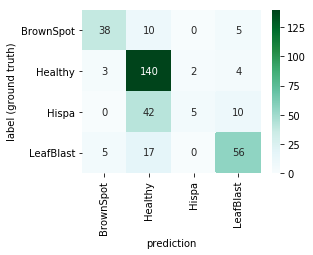

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 237	TRAIN	Loss: 0.63	Correct: 1981/3018(65.64%)
		VALID.:	Loss: 0.79	Correct: 235/337(69.73%)
----------------------------------------


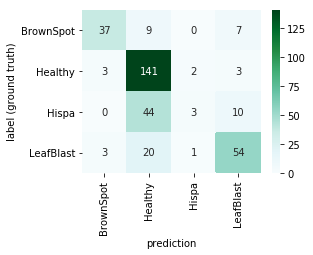

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 238	TRAIN	Loss: 0.61	Correct: 2003/3018(66.37%)
		VALID.:	Loss: 0.72	Correct: 231/337(68.55%)
----------------------------------------


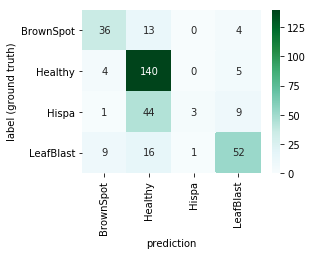

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 239	TRAIN	Loss: 1.57	Correct: 2017/3018(66.83%)
		VALID.:	Loss: 0.92	Correct: 229/337(67.95%)
----------------------------------------


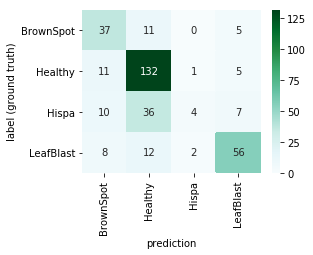

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 240	TRAIN	Loss: 0.62	Correct: 2013/3018(66.7%)
		VALID.:	Loss: 0.52	Correct: 237/337(70.33%)
----------------------------------------


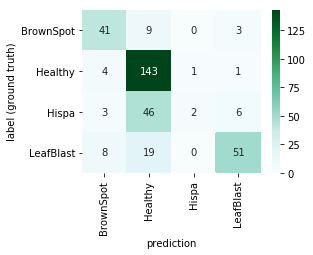

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 241	TRAIN	Loss: 0.69	Correct: 2006/3018(66.47%)
		VALID.:	Loss: 0.9	Correct: 232/337(68.84%)
----------------------------------------


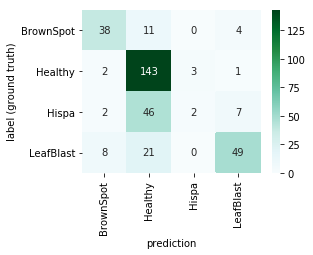

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 242	TRAIN	Loss: 0.72	Correct: 1988/3018(65.87%)
		VALID.:	Loss: 1.18	Correct: 238/337(70.62%)
----------------------------------------


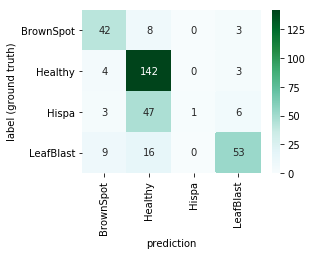

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 243	TRAIN	Loss: 0.34	Correct: 2003/3018(66.37%)
		VALID.:	Loss: 0.86	Correct: 234/337(69.44%)
----------------------------------------


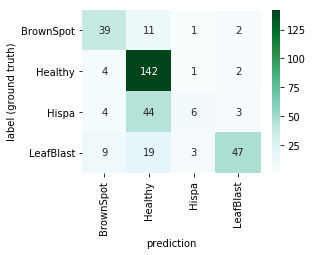

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 244	TRAIN	Loss: 0.99	Correct: 2022/3018(67.0%)
		VALID.:	Loss: 0.9	Correct: 240/337(71.22%)
----------------------------------------


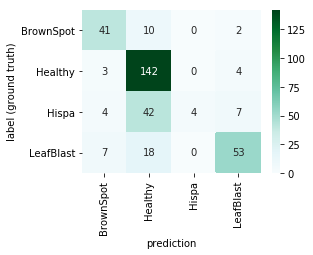

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 245	TRAIN	Loss: 0.75	Correct: 2011/3018(66.63%)
		VALID.:	Loss: 0.78	Correct: 232/337(68.84%)
----------------------------------------


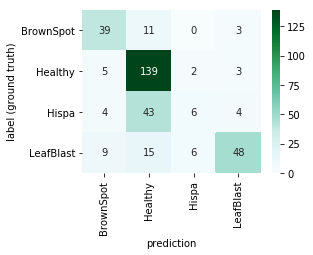

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 246	TRAIN	Loss: 1.0	Correct: 2012/3018(66.67%)
		VALID.:	Loss: 0.66	Correct: 235/337(69.73%)
----------------------------------------


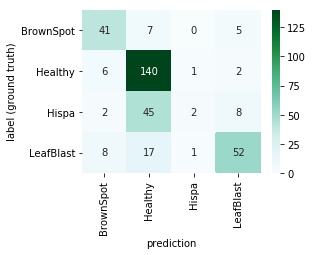

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 247	TRAIN	Loss: 1.15	Correct: 1982/3018(65.67%)
		VALID.:	Loss: 0.85	Correct: 230/337(68.25%)
----------------------------------------


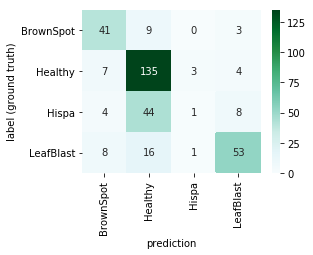

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 248	TRAIN	Loss: 1.24	Correct: 1994/3018(66.07%)
		VALID.:	Loss: 1.04	Correct: 240/337(71.22%)
----------------------------------------


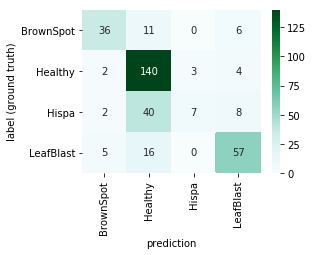

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 249	TRAIN	Loss: 0.61	Correct: 2004/3018(66.4%)
		VALID.:	Loss: 0.96	Correct: 230/337(68.25%)
----------------------------------------


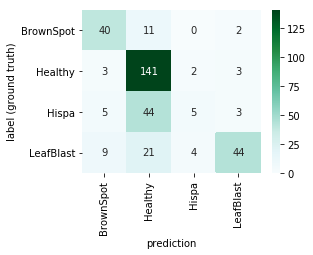

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 250	TRAIN	Loss: 0.27	Correct: 2011/3018(66.63%)
		VALID.:	Loss: 0.86	Correct: 236/337(70.03%)
----------------------------------------


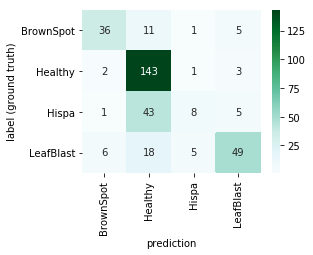

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 251	TRAIN	Loss: 1.02	Correct: 1985/3018(65.77%)
		VALID.:	Loss: 0.93	Correct: 237/337(70.33%)
----------------------------------------


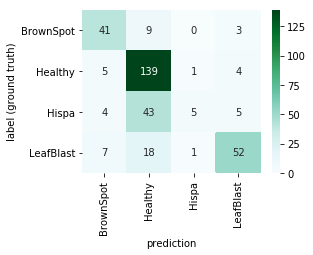

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 252	TRAIN	Loss: 0.75	Correct: 2010/3018(66.6%)
		VALID.:	Loss: 0.96	Correct: 238/337(70.62%)
----------------------------------------


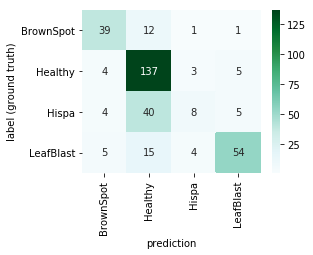

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 253	TRAIN	Loss: 0.86	Correct: 1999/3018(66.24%)
		VALID.:	Loss: 0.76	Correct: 236/337(70.03%)
----------------------------------------


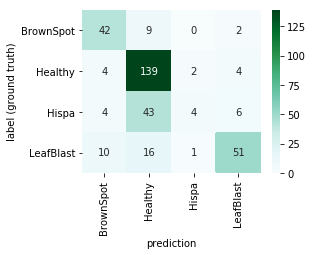

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 254	TRAIN	Loss: 1.08	Correct: 2011/3018(66.63%)
		VALID.:	Loss: 1.01	Correct: 234/337(69.44%)
----------------------------------------


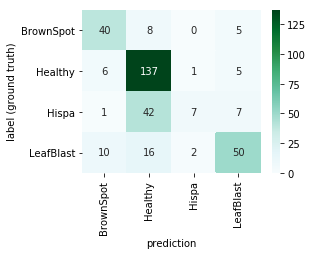

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 255	TRAIN	Loss: 1.2	Correct: 2008/3018(66.53%)
		VALID.:	Loss: 0.67	Correct: 237/337(70.33%)
----------------------------------------


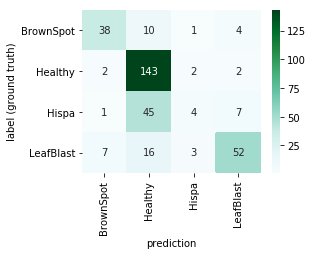

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 256	TRAIN	Loss: 0.6	Correct: 1993/3018(66.04%)
		VALID.:	Loss: 0.78	Correct: 238/337(70.62%)
----------------------------------------


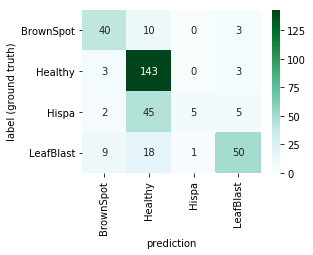

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 257	TRAIN	Loss: 0.82	Correct: 2001/3018(66.3%)
		VALID.:	Loss: 1.0	Correct: 228/337(67.66%)
----------------------------------------


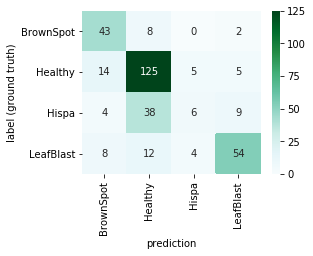

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 258	TRAIN	Loss: 1.66	Correct: 2013/3018(66.7%)
		VALID.:	Loss: 0.8	Correct: 234/337(69.44%)
----------------------------------------


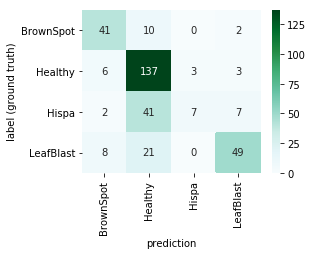

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 259	TRAIN	Loss: 1.49	Correct: 1983/3018(65.71%)
		VALID.:	Loss: 0.79	Correct: 236/337(70.03%)
----------------------------------------


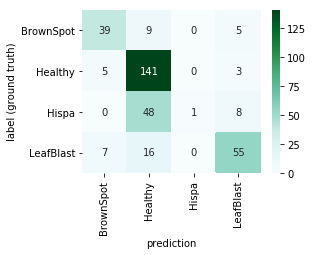

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 260	TRAIN	Loss: 0.72	Correct: 2004/3018(66.4%)
		VALID.:	Loss: 0.93	Correct: 234/337(69.44%)
----------------------------------------


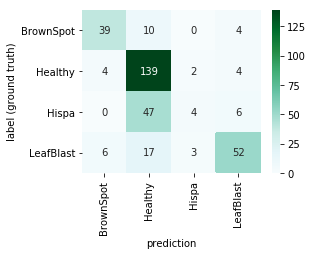

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 261	TRAIN	Loss: 0.8	Correct: 2006/3018(66.47%)
		VALID.:	Loss: 0.78	Correct: 229/337(67.95%)
----------------------------------------


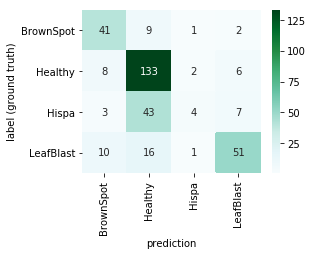

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 262	TRAIN	Loss: 0.8	Correct: 2004/3018(66.4%)
		VALID.:	Loss: 0.72	Correct: 233/337(69.14%)
----------------------------------------


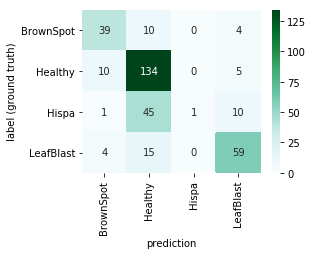

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 263	TRAIN	Loss: 1.18	Correct: 2011/3018(66.63%)
		VALID.:	Loss: 0.53	Correct: 235/337(69.73%)
----------------------------------------


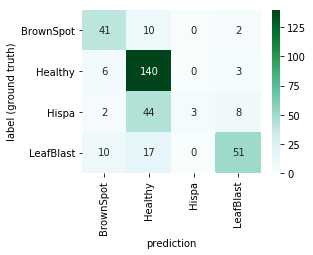

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 264	TRAIN	Loss: 1.15	Correct: 2013/3018(66.7%)
		VALID.:	Loss: 0.88	Correct: 236/337(70.03%)
----------------------------------------


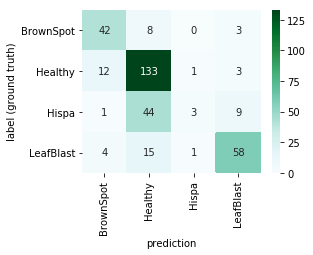

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 265	TRAIN	Loss: 0.95	Correct: 2009/3018(66.57%)
		VALID.:	Loss: 0.7	Correct: 240/337(71.22%)
----------------------------------------


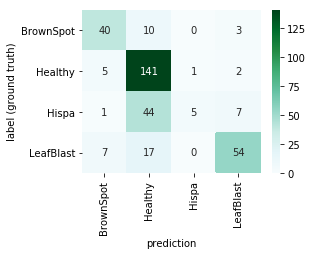

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 266	TRAIN	Loss: 0.73	Correct: 1993/3018(66.04%)
		VALID.:	Loss: 0.75	Correct: 242/337(71.81%)
----------------------------------------


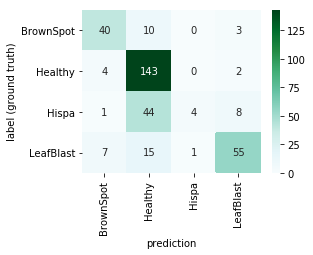

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 267	TRAIN	Loss: 0.94	Correct: 2002/3018(66.34%)
		VALID.:	Loss: 0.91	Correct: 232/337(68.84%)
----------------------------------------


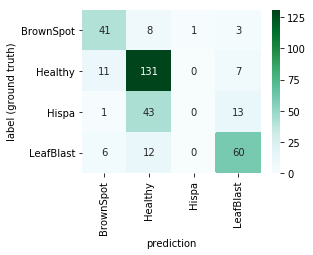

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 268	TRAIN	Loss: 0.58	Correct: 2014/3018(66.73%)
		VALID.:	Loss: 0.91	Correct: 234/337(69.44%)
----------------------------------------


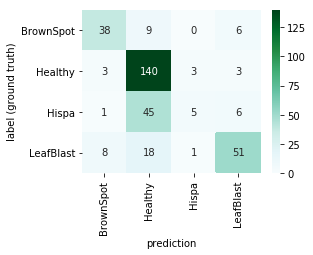

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 269	TRAIN	Loss: 1.0	Correct: 1989/3018(65.9%)
		VALID.:	Loss: 0.62	Correct: 229/337(67.95%)
----------------------------------------


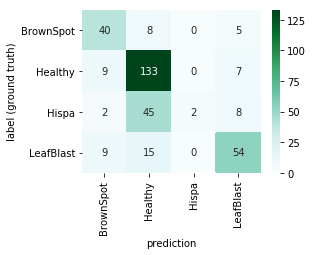

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 270	TRAIN	Loss: 0.64	Correct: 1992/3018(66.0%)
		VALID.:	Loss: 0.98	Correct: 240/337(71.22%)
----------------------------------------


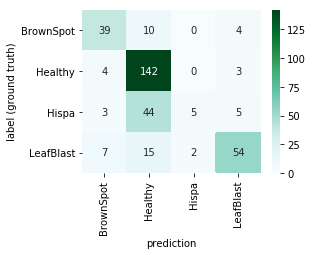

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 271	TRAIN	Loss: 0.82	Correct: 2006/3018(66.47%)
		VALID.:	Loss: 0.84	Correct: 229/337(67.95%)
----------------------------------------


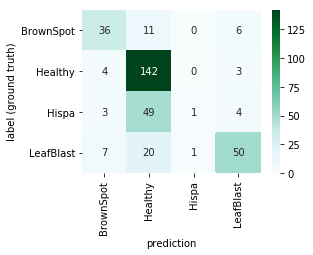

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 272	TRAIN	Loss: 0.75	Correct: 2017/3018(66.83%)
		VALID.:	Loss: 1.23	Correct: 228/337(67.66%)
----------------------------------------


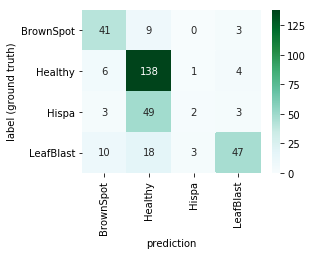

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 273	TRAIN	Loss: 1.65	Correct: 2020/3018(66.93%)
		VALID.:	Loss: 1.0	Correct: 233/337(69.14%)
----------------------------------------


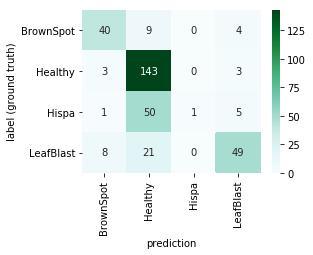

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 274	TRAIN	Loss: 1.21	Correct: 2015/3018(66.77%)
		VALID.:	Loss: 0.89	Correct: 231/337(68.55%)
----------------------------------------


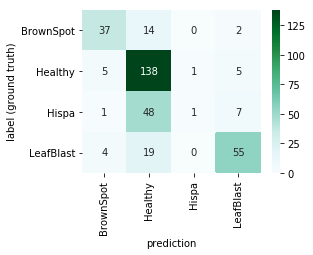

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 275	TRAIN	Loss: 0.95	Correct: 1997/3018(66.17%)
		VALID.:	Loss: 0.7	Correct: 237/337(70.33%)
----------------------------------------


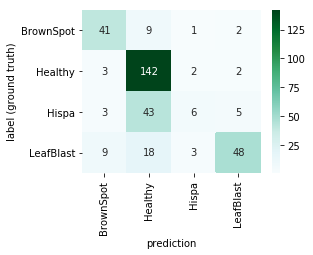

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 276	TRAIN	Loss: 0.86	Correct: 2000/3018(66.27%)
		VALID.:	Loss: 1.01	Correct: 234/337(69.44%)
----------------------------------------


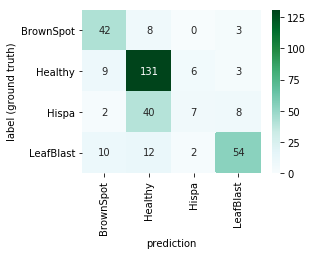

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 277	TRAIN	Loss: 1.17	Correct: 2017/3018(66.83%)
		VALID.:	Loss: 1.0	Correct: 241/337(71.51%)
----------------------------------------


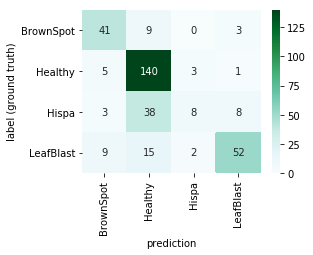

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 278	TRAIN	Loss: 0.77	Correct: 2005/3018(66.43%)
		VALID.:	Loss: 0.69	Correct: 235/337(69.73%)
----------------------------------------


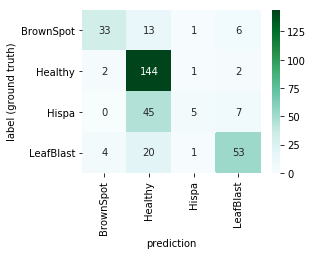

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 279	TRAIN	Loss: 1.39	Correct: 2001/3018(66.3%)
		VALID.:	Loss: 1.01	Correct: 215/337(63.8%)
----------------------------------------


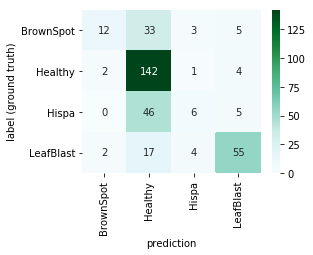

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 280	TRAIN	Loss: 0.29	Correct: 1992/3018(66.0%)
		VALID.:	Loss: 0.73	Correct: 242/337(71.81%)
----------------------------------------


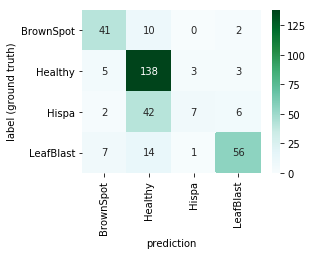

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 281	TRAIN	Loss: 0.72	Correct: 2027/3018(67.16%)
		VALID.:	Loss: 0.79	Correct: 238/337(70.62%)
----------------------------------------


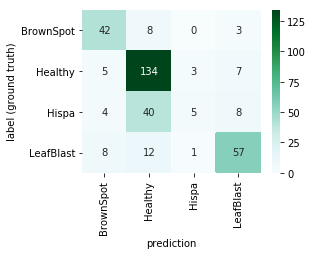

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 282	TRAIN	Loss: 1.08	Correct: 2046/3018(67.79%)
		VALID.:	Loss: 0.82	Correct: 233/337(69.14%)
----------------------------------------


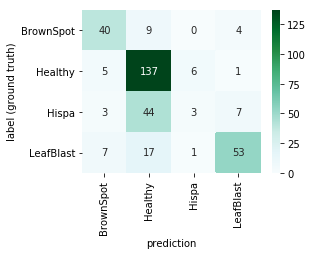

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 283	TRAIN	Loss: 1.04	Correct: 2010/3018(66.6%)
		VALID.:	Loss: 1.58	Correct: 228/337(67.66%)
----------------------------------------


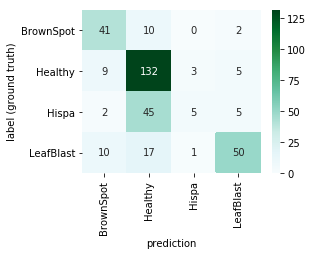

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 284	TRAIN	Loss: 0.86	Correct: 1991/3018(65.97%)
		VALID.:	Loss: 0.94	Correct: 235/337(69.73%)
----------------------------------------


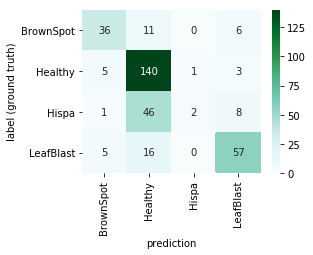

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 285	TRAIN	Loss: 0.72	Correct: 2023/3018(67.03%)
		VALID.:	Loss: 0.82	Correct: 239/337(70.92%)
----------------------------------------


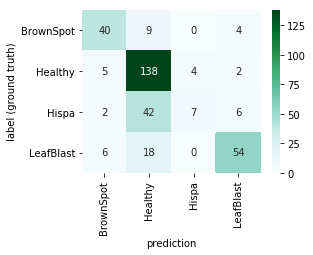

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 286	TRAIN	Loss: 0.47	Correct: 2029/3018(67.23%)
		VALID.:	Loss: 0.8	Correct: 239/337(70.92%)
----------------------------------------


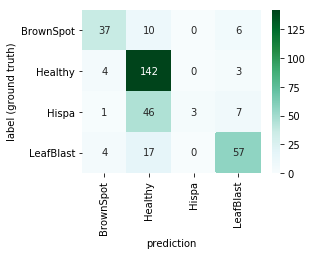

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 287	TRAIN	Loss: 1.3	Correct: 2043/3018(67.69%)
		VALID.:	Loss: 0.97	Correct: 232/337(68.84%)
----------------------------------------


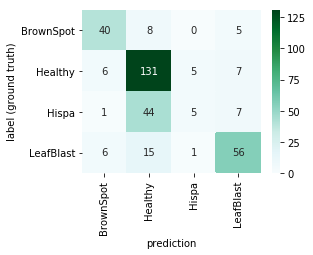

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 288	TRAIN	Loss: 0.69	Correct: 2025/3018(67.1%)
		VALID.:	Loss: 0.85	Correct: 236/337(70.03%)
----------------------------------------


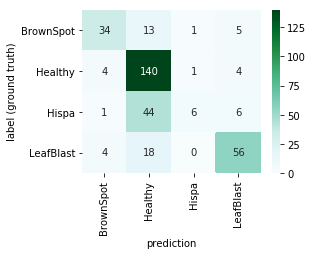

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 289	TRAIN	Loss: 0.98	Correct: 2005/3018(66.43%)
		VALID.:	Loss: 0.95	Correct: 239/337(70.92%)
----------------------------------------


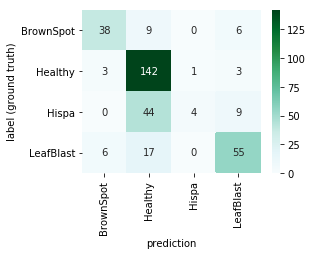

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 290	TRAIN	Loss: 0.69	Correct: 1999/3018(66.24%)
		VALID.:	Loss: 0.82	Correct: 230/337(68.25%)
----------------------------------------


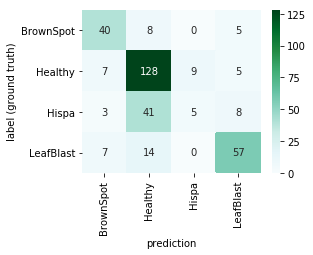

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 291	TRAIN	Loss: 0.74	Correct: 2009/3018(66.57%)
		VALID.:	Loss: 0.54	Correct: 230/337(68.25%)
----------------------------------------


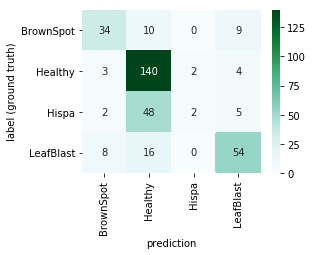

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 292	TRAIN	Loss: 0.92	Correct: 1957/3018(64.84%)
		VALID.:	Loss: 1.01	Correct: 236/337(70.03%)
----------------------------------------


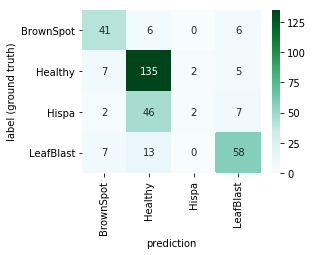

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 293	TRAIN	Loss: 0.4	Correct: 2024/3018(67.06%)
		VALID.:	Loss: 0.92	Correct: 233/337(69.14%)
----------------------------------------


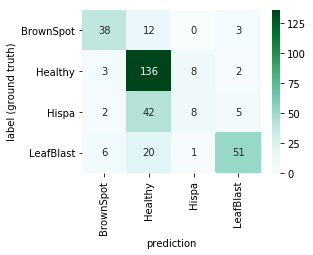

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 294	TRAIN	Loss: 0.58	Correct: 1990/3018(65.94%)
		VALID.:	Loss: 0.66	Correct: 232/337(68.84%)
----------------------------------------


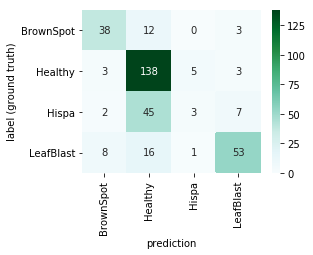

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 295	TRAIN	Loss: 0.9	Correct: 2015/3018(66.77%)
		VALID.:	Loss: 0.89	Correct: 236/337(70.03%)
----------------------------------------


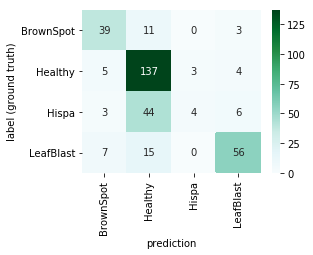

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 296	TRAIN	Loss: 0.86	Correct: 2001/3018(66.3%)
		VALID.:	Loss: 0.78	Correct: 226/337(67.06%)
----------------------------------------


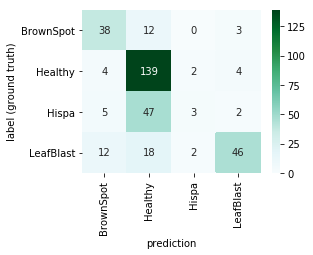

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 297	TRAIN	Loss: 0.97	Correct: 2000/3018(66.27%)
		VALID.:	Loss: 1.05	Correct: 229/337(67.95%)
----------------------------------------


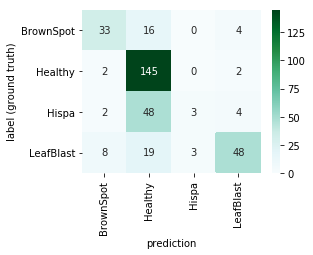

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 298	TRAIN	Loss: 0.56	Correct: 2015/3018(66.77%)
		VALID.:	Loss: 0.62	Correct: 235/337(69.73%)
----------------------------------------


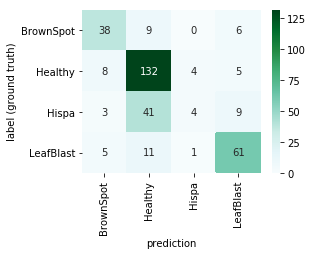

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 299	TRAIN	Loss: 0.91	Correct: 2043/3018(67.69%)
		VALID.:	Loss: 0.97	Correct: 234/337(69.44%)
----------------------------------------


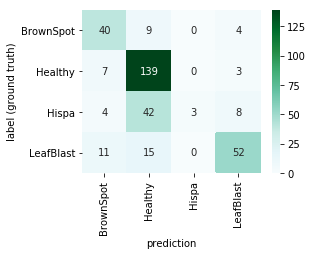

---- batch: 0(301)
---- batch: 100(301)
---- batch: 200(301)
---- batch: 300(301)
Epoch: 300	TRAIN	Loss: 0.68	Correct: 2010/3018(66.6%)
		VALID.:	Loss: 0.87	Correct: 238/337(70.62%)
----------------------------------------


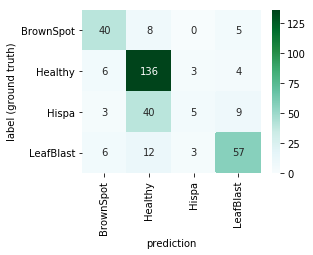

End.
Duration: 28690 seconds


In [26]:
train_losses, valid_losses, train_corrects, valid_corrects = \
    train(model,
          criterion,
          optimizer,
          train_loader, valid_loader, 
          n_epoch=300)

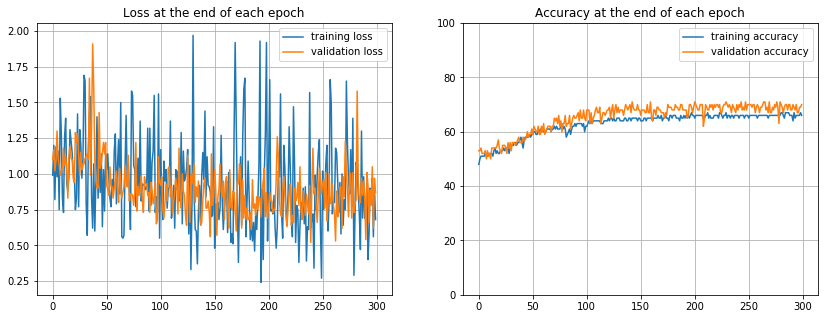

In [27]:
plot_train_results(train_losses, valid_losses,
                   train_corrects, valid_corrects,
                   len(train_loader.sampler.indices), len(valid_loader.sampler.indices))

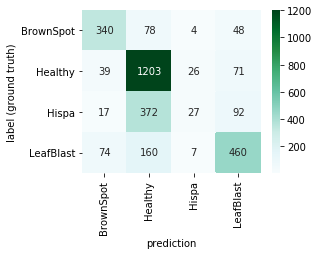

Training accuracy: 67.26 %


In [28]:
evaluate_model(model, train_loader, DEVICE, 'Training')

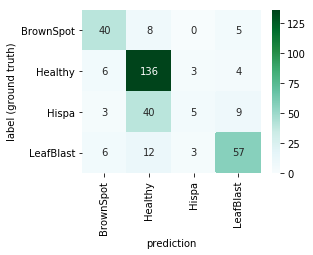

Validation accuracy: 70.62 %


In [29]:
evaluate_model(model, valid_loader, DEVICE, 'Validation')